## Parte 1 - Linear Regression

In [52]:
#notebook settings
%matplotlib inline

#import some useful libraries and utilities
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold

#setting some paths
path1='./cereales/'
path2='./credit/'

#parameters to try
params1 = np.array([0.2e-3, 0.4e-3, 0.6e-3, 0.8e-3, 1.0e-3])
params2 = np.linspace(4.0e-7,4.5e-7,5)

In [39]:
#Helper functions

"""
Function to generate histogram of winners (alphas)
"""
def make_hist(winners,parms):
    winners = np.array(winners)
    freqs = np.zeros(5)
    for i in xrange(5):
        freqs[i] = np.sum(parms[i]==winners)

    labels = ['alp1', 'alp2', 'alp3', 'alp4', 'alp5']
    pos = np.arange(len(labels))
    width = 1.0 
    ax = plt.axes()
    ax.set_xticks(pos + (width / 2))
    ax.set_xticklabels(labels)
    plt.bar(pos, freqs, width, color='r')
    plt.title('Best alpha for each dataset')
    plt.show()

def solve_all(algorithm, params=None, data_func=None):
    if params is not None:
        #list with winners-alphas
        winners = list()

    for i in xrange(20):
        #Loading dataset
        tr_file = path1+'cereales-tr-{0}.npy'.format(i)
        ts_file = path1+'cereales-ts-{0}.npy'.format(i)
        tr_data = np.load(tr_file)
        ts_data = np.load(ts_file)
        
        if data_func is not None:
            X_tr = data_func(tr_data[:,:-1])
        else: 
            X_tr = tr_data[:,:-1]
        y_tr = np.ascontiguousarray(tr_data[:,-1])
        #Adding column of 1's
        m,n = X_tr.shape
        X_tr = np.concatenate((np.ones((m,1)),X_tr),axis=1)

        if data_func is not None:
            X_ts = data_func(ts_data[:,:-1])
        else: 
            X_ts = ts_data[:,:-1]
        y_ts = np.ascontiguousarray(ts_data[:,-1])
        #Adding column of 1's
        m,n = X_ts.shape
        X_ts = np.concatenate((np.ones((m,1)),X_ts),axis=1)

        if params is not None:
            alpha,tr_cost,ts_cost = cross_alpha(X_tr, y_tr, algorithm, params)
            winners.append(alpha)
            beta,it = algorithm(X_tr, y_tr, alpha)
        else:
            beta,it = algorithm(X_tr, y_tr)
        print "###########################################################"
        print "Dataset: {0}".format(i)
        if params is not None:
            print 'Best alpha: {0}'.format(alpha)
            fig = plt.figure()
            fig.set_figheight(7)
            fig.set_figwidth(13)
            fig.add_subplot(121)
            plt.boxplot(tr_cost, showmeans=True, meanline=True)
            fig.add_subplot(122)
            plt.boxplot(ts_cost, showmeans=True, meanline=True)
            plt.show()
        print 'Training error: {0}'.format(mse(X_tr,y_tr,beta))
        print 'Testing error: {0}'.format(mse(X_ts,y_ts,beta))
        print 'N° iterations: {0}'.format(it)
        print 'Beta: {0}'.format(beta)
        print "###########################################################"
        print '\n'
    
    if params is not None:
        make_hist(winners,params)

In [59]:
#Overall cost function for linear regresion
def J(X, y, beta):
    h = np.dot(X,beta)
    diff = h-y
    return 0.5*np.dot(diff,diff)

#Mean Squared Error 
def mse(X, y, beta):
    M,N = X.shape
    h = np.dot(X,beta)
    diff = h-y
    return (1./(M-1))*np.dot(diff,diff)

#Batch gradient descent for linear regression
def gd_batch(X, y, alpha, eps=1e-5, max_iter=100000):
    M,N = X.shape
    beta = np.zeros(N)
    J1 = J(X,y,beta) #loss at previous iteration
    for i in xrange(max_iter):
        J0 = J1
        h = np.dot(X,beta)
        dJ = np.dot(X.T,h-y)
        beta -= alpha*dJ
        J1 = J(X,y,beta)
        if np.abs(J1-J0)/J0 < eps:
            break
    return (beta,i+1)

#Online gradient descent for linear regression
"""
Implmentation can be seen on gd.pyx. It was
made with Cython for seepdup
"""
#from gd import gd_online
def gd_online(X, y, alpha, eps=1e-5, max_iter=100000):
    M,N = X.shape
    beta = np.zeros(N)
    J1 = J(X,y,beta) #loss at previous iteration
    for i in xrange(max_iter):
        J0 = J1
        for m in xrange(M):
            beta -= alpha*(np.dot(X[m],beta)-y[m])*X[m]
        J1 = J(X,y,beta)
        if np.abs(J1-J0)/J0 < eps: break
    return (beta,i+1)

#Newton-Raphson method for linear regression
def nr_linear(X, y, eps=1e-5, max_iter=100000):
    M,N = X.shape
    beta = np.zeros(N)
    J1 = J(X,y,beta) #loss at previous iteration 
    Hess = np.dot(X.T,X) #Hessian matrix
    for i in xrange(max_iter):
        J0 = J1
        h = np.dot(X,beta)
        dJ = np.dot(X.T,h-y)
        beta -= np.linalg.solve(Hess, dJ)
        J1 = J(X,y,beta)
        if np.abs(J1-J0)/J0 < eps: break
    return (beta,i+1)

#Compute weights for all samples in X matrix, respect to x0
def weight(X, x0, tau):
    Diff = X - x0
    Diff *= Diff
    return np.exp(-1*np.sum(Diff,axis=1)/(2.*tau))

#weighted cost function
def wJ(X, y, beta, w):
    h = np.dot(X,beta)
    diff = h-y
    diff **=2
    return 0.5*np.dot(w,diff)

#Find best beta for locally weighted linear regression, with test x0
def min_weighted(X, y, x0, tau):
    #vector with weights
    W = np.diag(weight(X,x0,tau))
    M = np.dot(X.T, np.dot(W, X))
    b = np.dot(X.T, np.dot(W, y))
    return np.linalg.solve(M,b)

def rescale(M, a=0., b=1.):
    """ Rescale features of M to [a,b] range """
    #max and min vectors
    maxv = np.max(M, axis=0)
    minv = np.min(M, axis=0)
    return (b-a)*M/(maxv-minv) + (a*maxv-b*minv)/(maxv-minv)

def normalize(M):
    #mean and standard deviation vectors
    meanv = np.mean(M, axis=0)
    stdv = np.std(M, axis=0)
    return (M-meanv)/stdv

In [41]:
""" Find the best learning parameter for algorithm, between 
parameters in params using k-fold cross validation """
def cross_alpha(X, y, algorithm, params):
    #creating kfold
    m,n = X.shape
    kf = KFold(m, n_folds=5)
    tr_cost = np.empty((5,5))
    ts_cost = np.empty((5,5))
    i = 0 #index of fold
    
    for tr_index,ts_index in kf:
        j = 0 #index of parameter
        for param in params:
            X_train, X_test = X[tr_index], X[ts_index]
            y_train, y_test = y[tr_index], y[ts_index]
            beta,_ = algorithm(X_train, y_train, alpha=param)
            tr_cost[i,j] = mse(X_train, y_train, beta)
            ts_cost[i,j] = mse(X_test, y_test, beta)
            j += 1
        i += 1
        
    #arrays with mean costs for each alpha
    tr_mean = np.mean(tr_cost, axis=0) 
    ts_mean = np.mean(ts_cost, axis=0)
    return params[np.argmin(ts_mean)], tr_cost, ts_cost

def cross_tau(X, y, params):
    #creating kfolds
    m,n = X.shape
    kf = KFold(m, n_folds=5)
    
    for tr_index,ts_index in kf:
        for tau in params:
            X_train, X_test = X[tr_index], X[ts_index]
            y_train, y_test = y[tr_index], y[ts_index]
            
    
    return

In [5]:
m,n = X.shape
x0 = np.random.random(n)
min_weighted(X,y,x0,0.5)

NameError: name 'X' is not defined

## 1.1)

### Gradient descent batch for raw data

###########################################################
Dataset: 0
Best alpha: 4.5e-07


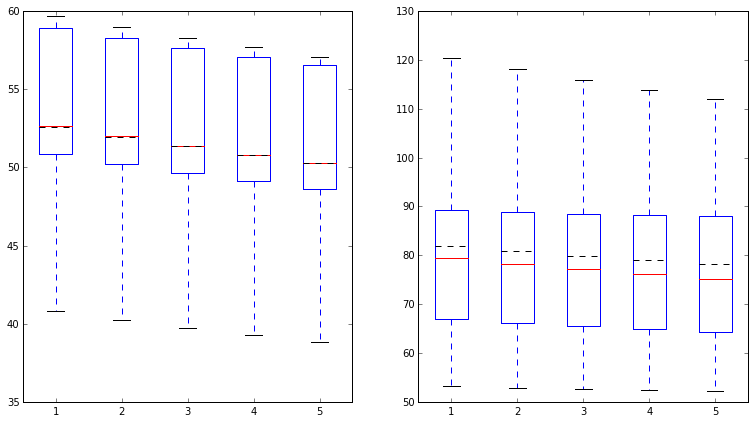

Training error: 47.7018651247
Testing error: 98.5365507026
N° iterations: 41839
Beta: [ 1.45007051 -0.07488509  3.6586664  -3.18223332 -0.06170004  3.49975134
  2.64216044  0.01071132 -0.01107893 -0.13169927  3.28244344  0.81753365
  1.61203648]
###########################################################


###########################################################
Dataset: 1
Best alpha: 4.5e-07


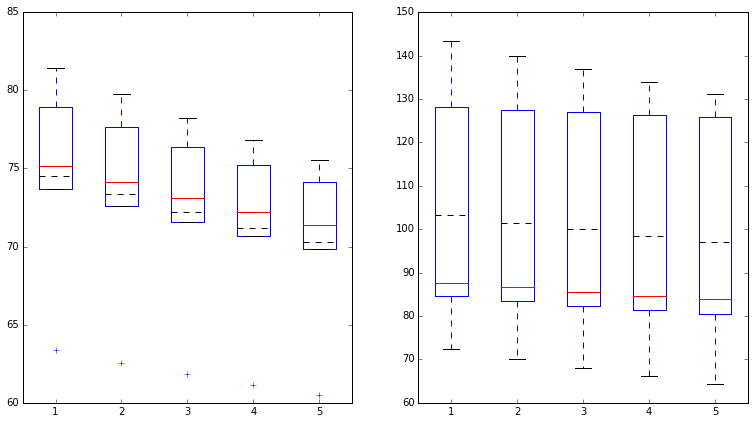

Training error: 64.7550597054
Testing error: 48.2315757796
N° iterations: 37395
Beta: [ 1.51151842 -0.13138068  3.85681757 -2.38975838 -0.0335923   2.53120612
  2.56108045  0.09368966  0.02998656 -0.12676098  2.72679839  0.78423382
  1.58448175]
###########################################################


###########################################################
Dataset: 2
Best alpha: 4.5e-07


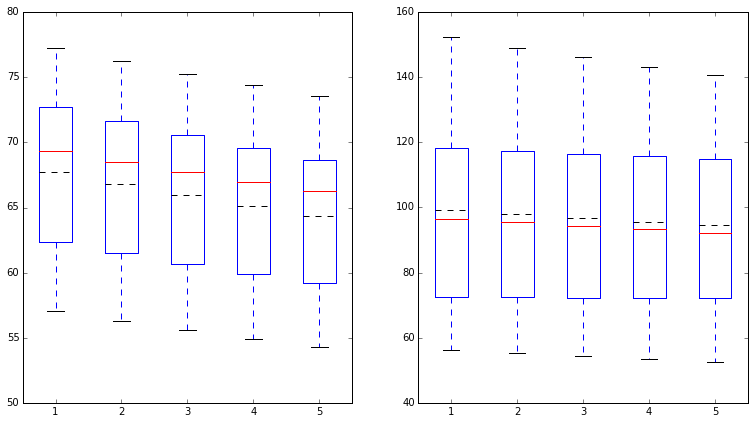

Training error: 60.7481463585
Testing error: 79.3615414274
N° iterations: 35558
Beta: [ 1.17969386 -0.13953799  3.78294308 -1.82756036 -0.03305847  2.50888648
  2.71785523  0.15927905  0.02106107 -0.13489473  2.33540385  0.68729504
  1.32478924]
###########################################################


###########################################################
Dataset: 3
Best alpha: 4.5e-07


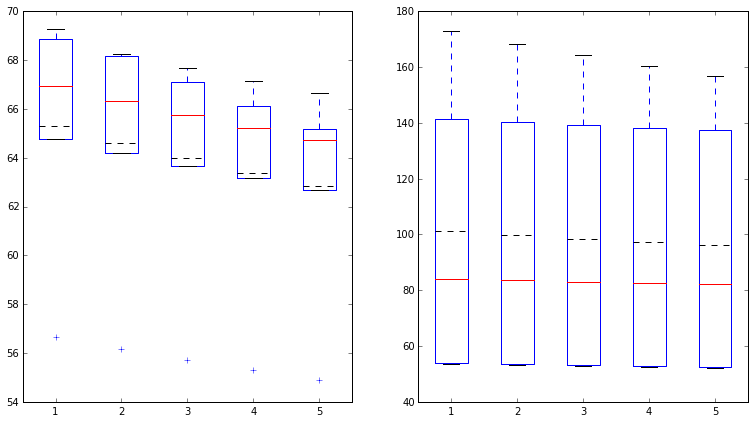

Training error: 58.9987667645
Testing error: 97.6149558458
N° iterations: 33429
Beta: [  1.25203426e+00   1.18167168e-03   3.01875186e+00  -2.88371921e+00
  -4.48843106e-02   3.51345829e+00   2.53504404e+00  -3.29583267e-01
  -5.33724219e-03  -1.66931668e-01   1.87341387e+00   5.78813824e-01
   1.45941431e+00]
###########################################################


###########################################################
Dataset: 4
Best alpha: 4.5e-07


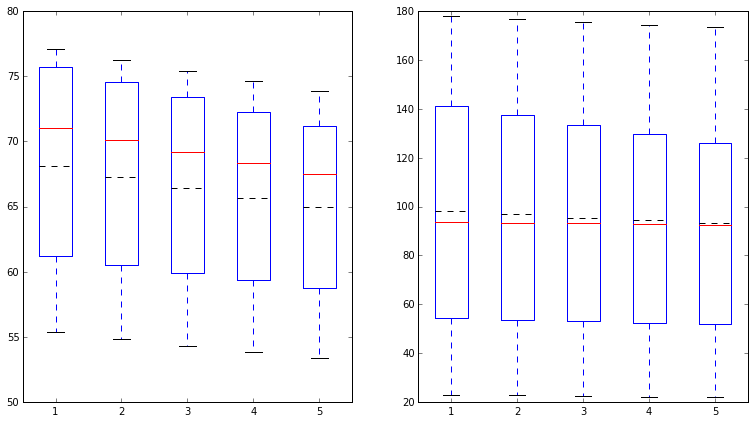

Training error: 60.3072912204
Testing error: 88.023192366
N° iterations: 33899
Beta: [ 1.24215199 -0.08193527  2.65716575 -2.15854073 -0.03925225  2.98855187
  2.71064704 -0.17171491  0.02214669 -0.15063159  2.70621456  0.82794457
  1.22588399]
###########################################################


###########################################################
Dataset: 5
Best alpha: 4.5e-07


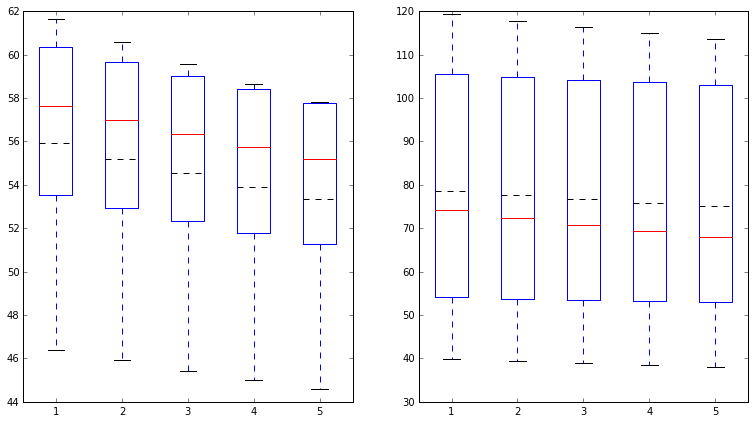

Training error: 50.8161360455
Testing error: 103.273046989
N° iterations: 37135
Beta: [ 1.20350502 -0.08930296  3.83324385 -2.45694911 -0.04535681  3.12053542
  2.55565498  0.00401994  0.02434499 -0.11672738  1.94519309  0.7931489
  1.26388671]
###########################################################


###########################################################
Dataset: 6
Best alpha: 4.5e-07


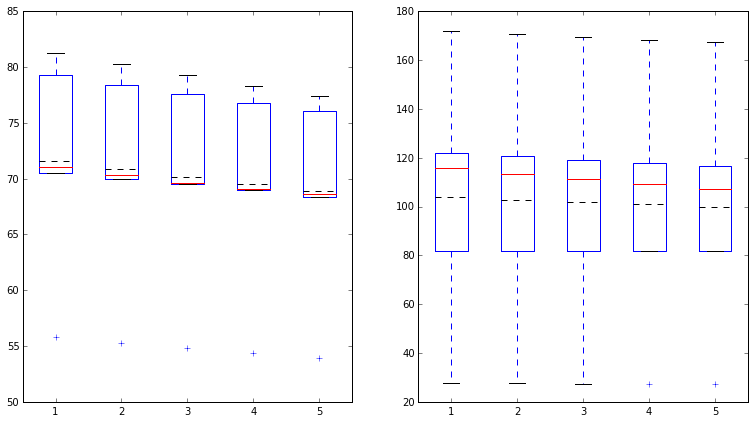

Training error: 65.6541052631
Testing error: 57.5892393027
N° iterations: 32693
Beta: [ 1.27903009 -0.03878925  3.40772812 -2.59294373 -0.02933009  3.04353951
  2.32056313 -0.29475475  0.01473876 -0.1526923   2.22168778  0.69725781
  1.34790144]
###########################################################


###########################################################
Dataset: 7
Best alpha: 4.5e-07


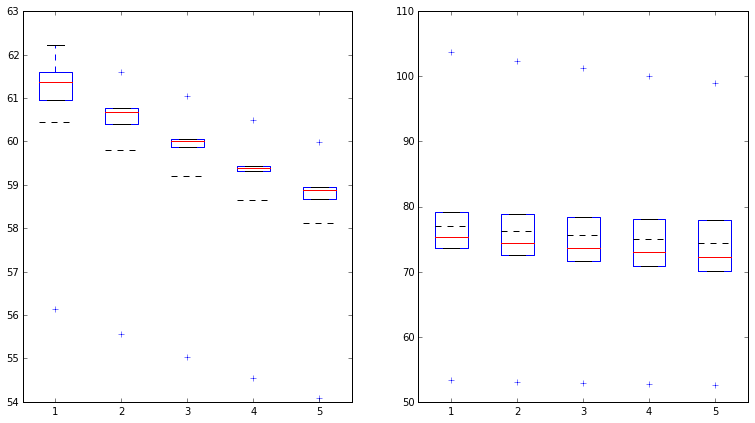

Training error: 55.4439862945
Testing error: 75.1149772436
N° iterations: 37075
Beta: [ 1.28365704 -0.08713122  3.98989369 -2.849145   -0.04344421  3.25455649
  2.5317626   0.11331768  0.01441116 -0.14838931  2.26488177  0.76079017
  1.49081129]
###########################################################


###########################################################
Dataset: 8
Best alpha: 4.5e-07


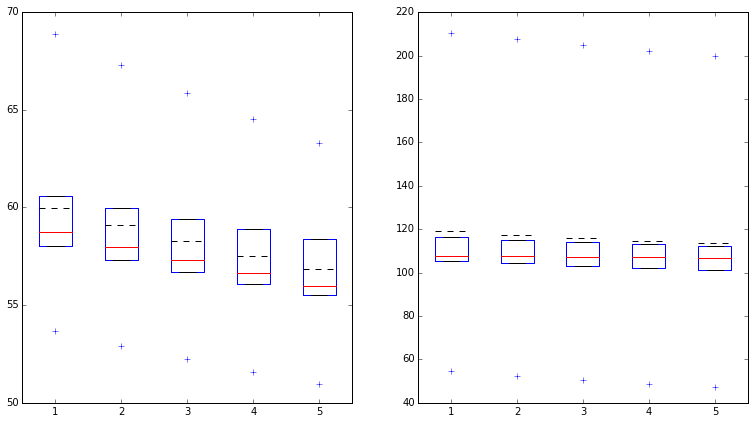

Training error: 54.5426469971
Testing error: 82.2107819498
N° iterations: 38927
Beta: [ 1.24561581 -0.07267351  3.2863172  -2.7469164  -0.05323766  3.01293599
  2.56609359  0.01704858  0.00336593 -0.12409025  3.19095961  0.80653327
  1.57989221]
###########################################################


###########################################################
Dataset: 9
Best alpha: 4.5e-07


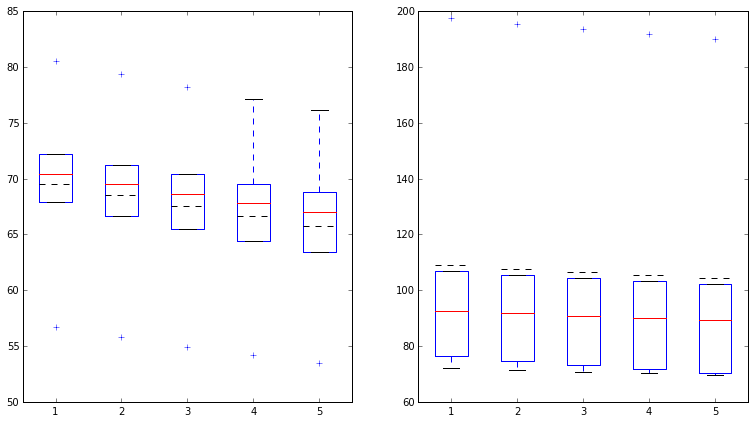

Training error: 62.4168368555
Testing error: 59.7595593067
N° iterations: 38408
Beta: [ 1.46658372 -0.10295414  4.0573884  -2.39316905 -0.03957536  2.27005469
  2.57954306  0.07813148  0.01603134 -0.14981853  2.72721511  0.84118777
  1.52602249]
###########################################################


###########################################################
Dataset: 10
Best alpha: 4.5e-07


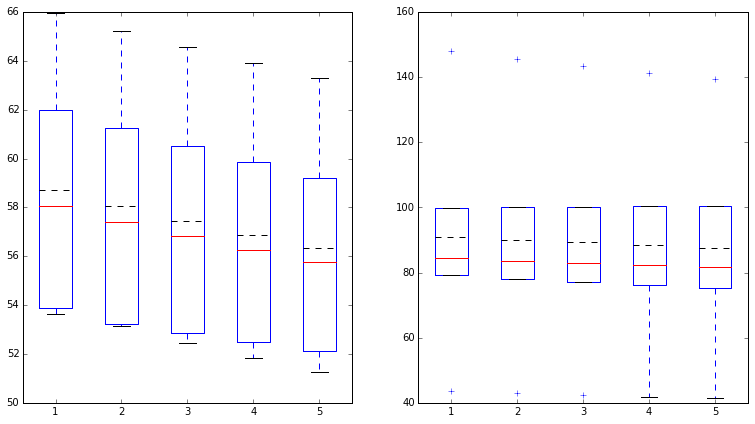

Training error: 54.2623055884
Testing error: 102.249628704
N° iterations: 35617
Beta: [ 1.16831853 -0.03918495  3.95638478 -2.63365326 -0.03014391  3.1621868
  2.18584239 -0.23403557  0.0088874  -0.08218795  1.50697396  0.74049203
  1.24216083]
###########################################################


###########################################################
Dataset: 11
Best alpha: 4.5e-07


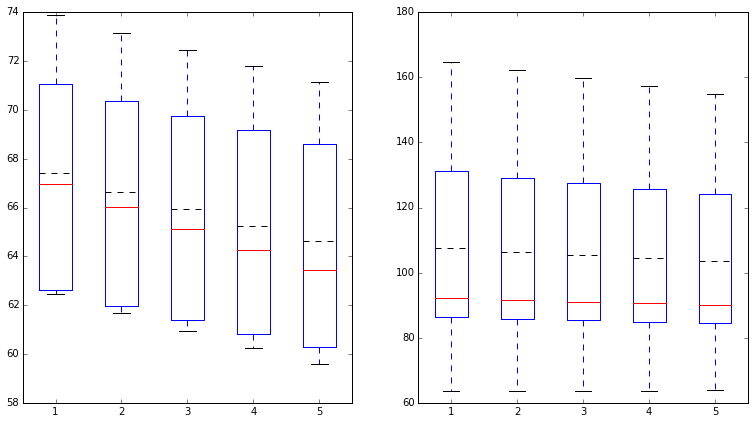

Training error: 62.0340545439
Testing error: 96.3581158257
N° iterations: 33306
Beta: [  1.10981655e+00  -5.10322177e-02   3.68956947e+00  -2.54729391e+00
  -4.67862581e-02   2.44906226e+00   2.47406756e+00   6.42013850e-02
   3.49242822e-03  -1.31328279e-01   1.88320918e+00   6.60243480e-01
   1.33877255e+00]
###########################################################


###########################################################
Dataset: 12
Best alpha: 4.5e-07


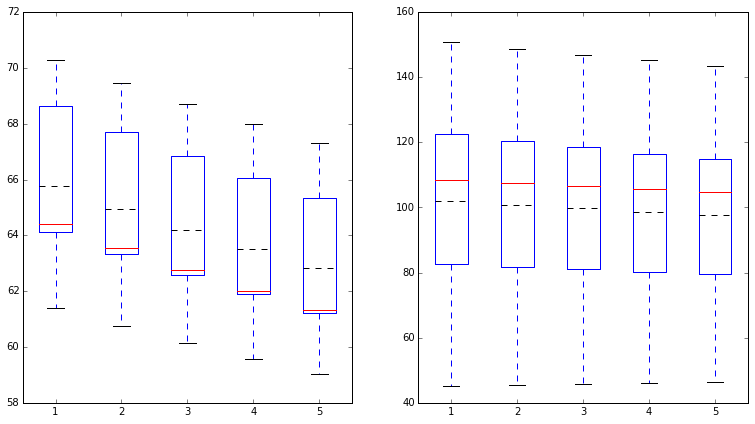

Training error: 60.1712404807
Testing error: 47.6982336899
N° iterations: 38458
Beta: [ 1.45433377 -0.08968786  4.24651413 -2.78368867 -0.03857028  2.92994807
  2.32117945  0.05748663  0.00854696 -0.10316297  2.88769513  0.78093322
  1.71517034]
###########################################################


###########################################################
Dataset: 13
Best alpha: 4.5e-07


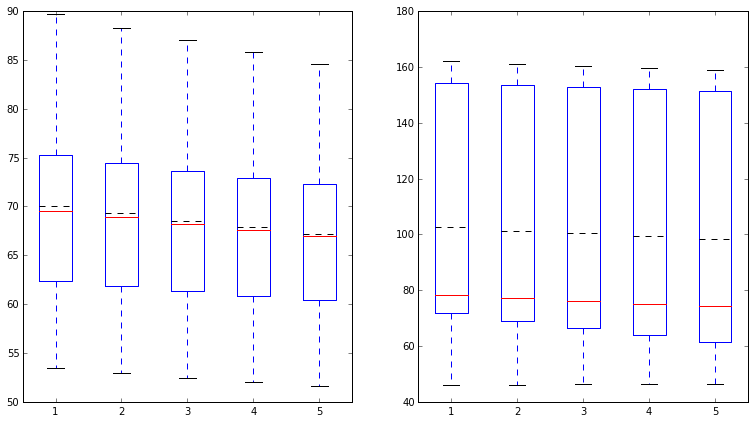

Training error: 63.8754224266
Testing error: 54.6855768246
N° iterations: 34544
Beta: [ 1.26294288 -0.06921313  3.7100431  -2.74170632 -0.04703039  2.85815788
  2.49956608 -0.02140664  0.01689035 -0.12755801  2.14607095  0.68777065
  1.60864618]
###########################################################


###########################################################
Dataset: 14
Best alpha: 4.5e-07


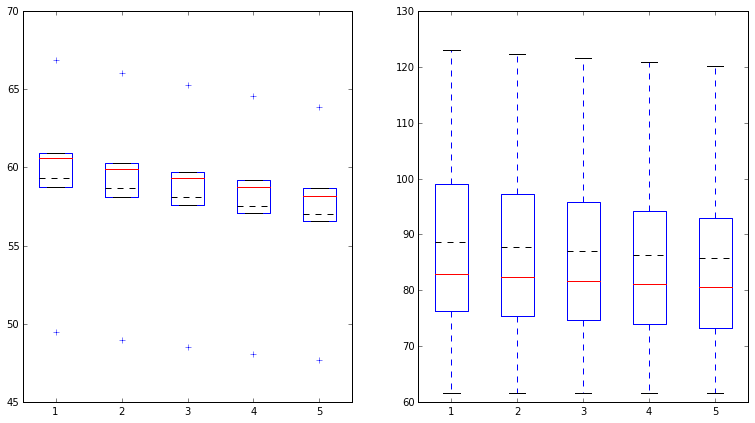

Training error: 55.3889121746
Testing error: 87.9559175097
N° iterations: 36435
Beta: [ 1.25097182 -0.06527964  4.28808828 -2.78390695 -0.03263313  2.25244654
  2.20500163  0.03132868  0.02280227 -0.0866293   2.26144347  0.67313098
  1.52788902]
###########################################################


###########################################################
Dataset: 15
Best alpha: 4.5e-07


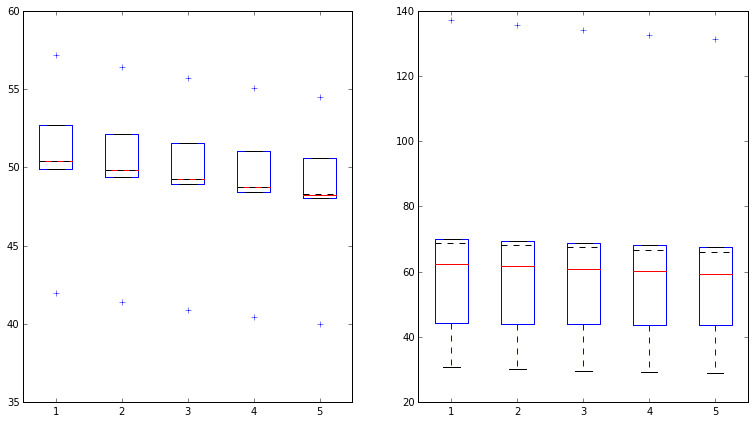

Training error: 46.1065815649
Testing error: 120.74160843
N° iterations: 41171
Beta: [ 1.43174894 -0.03773407  3.9914923  -2.78688194 -0.0362851   3.59588567
  2.08940944 -0.07587966 -0.00634996 -0.05640431  2.18350277  0.63561388
  1.13180144]
###########################################################


###########################################################
Dataset: 16
Best alpha: 4.5e-07


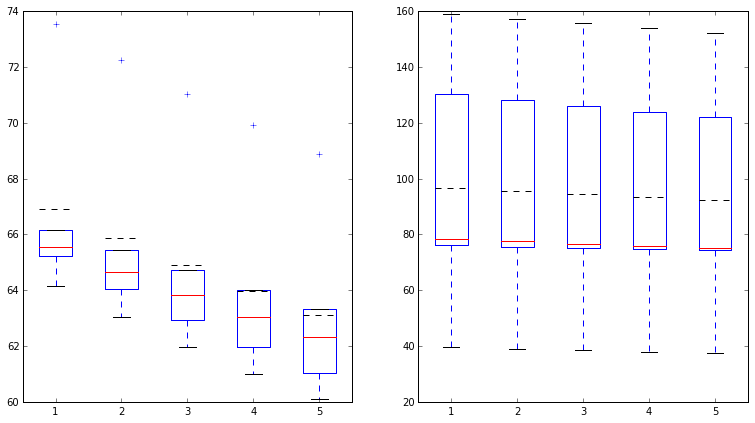

Training error: 58.7921426086
Testing error: 82.0169113703
N° iterations: 37313
Beta: [ 1.36353919 -0.14715022  3.46763084 -2.13118141 -0.0462796   2.57360503
  2.81836314  0.10845942  0.03626119 -0.10181231  2.47787117  0.62937244
  1.70474643]
###########################################################


###########################################################
Dataset: 17
Best alpha: 4.5e-07


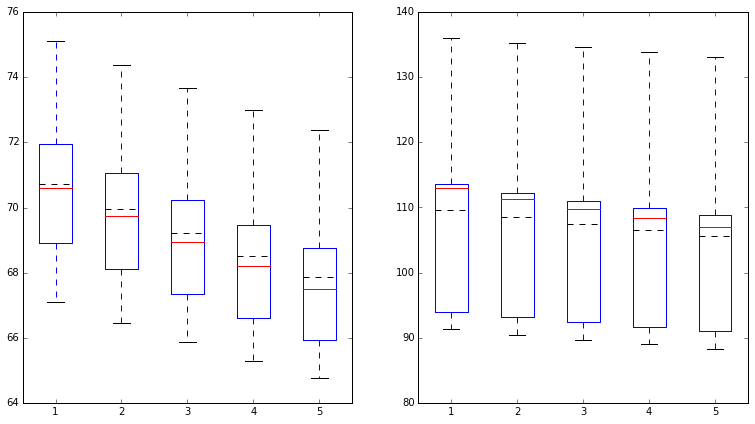

Training error: 65.6326333879
Testing error: 50.8059305089
N° iterations: 34370
Beta: [  1.43483394e+00   9.77333816e-03   3.23964259e+00  -3.05545702e+00
  -4.68517932e-02   3.28169124e+00   2.23782609e+00  -4.19906512e-01
   2.04841444e-03  -1.14762174e-01   2.38017662e+00   7.38252135e-01
   1.59065712e+00]
###########################################################


###########################################################
Dataset: 18
Best alpha: 4.5e-07


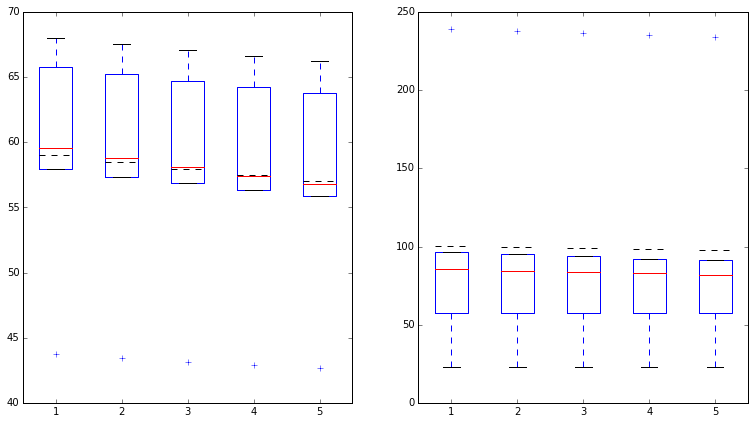

Training error: 56.5555399322
Testing error: 89.5246242367
N° iterations: 33340
Beta: [ 1.17370353 -0.07767876  3.53369067 -2.60439235 -0.03771718  3.58343137
  2.47778959  0.24231999 -0.00683109 -0.11976592  1.90929452  0.64435988
  1.29348523]
###########################################################


###########################################################
Dataset: 19
Best alpha: 4.5e-07


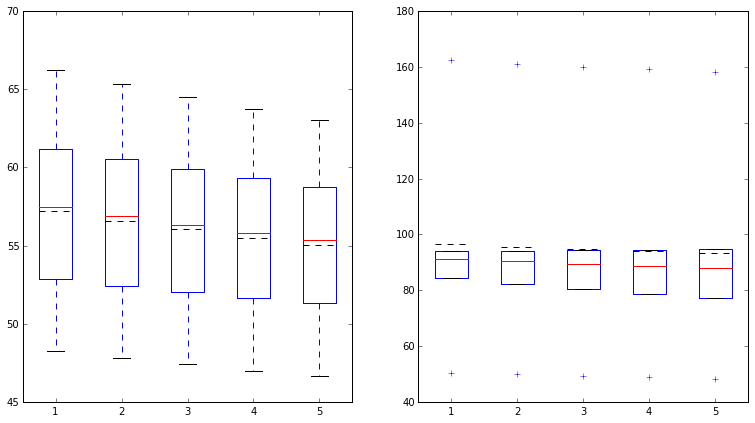

Training error: 53.8965499152
Testing error: 101.423157308
N° iterations: 36769
Beta: [ 1.27256142 -0.05788255  4.26424669 -2.18488152 -0.01905394  2.9310861
  2.01213426 -0.25756531  0.00593722 -0.10241576  2.55634214  0.77001516
  1.23669942]
###########################################################




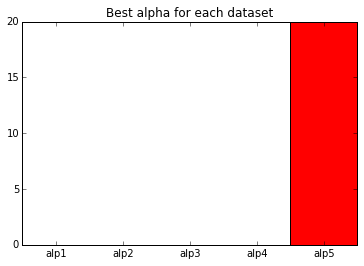

In [48]:
solve_all(gd_batch, params=params2)

### Gradient descent batch for rescaled data [0,1]

###########################################################
Dataset: 0
Best alpha: 0.0006


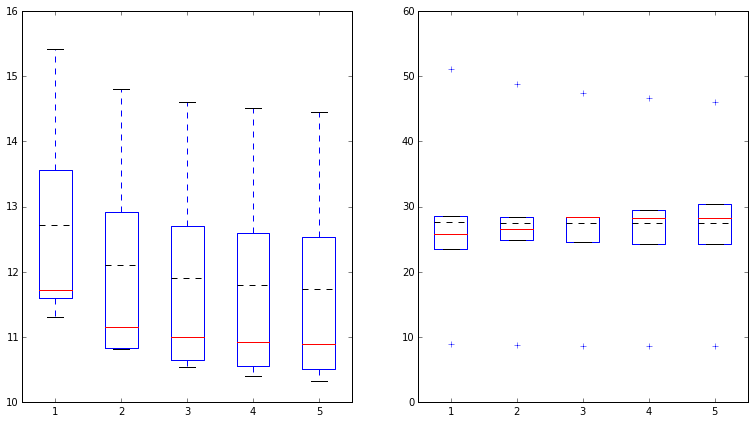

Training error: 13.0062050605
Testing error: 65.2571301369
N° iterations: 7718
Beta: [ 39.12819425 -21.12211183  18.39155828 -16.19472306 -15.69925885
  40.12054606  16.08049095 -16.64772494  -5.87286996 -13.08148087
   5.18930831   9.8497999   23.09701364]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.001


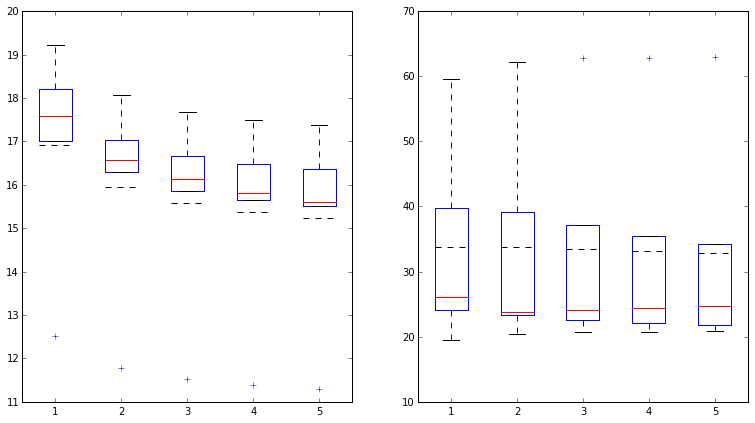

Training error: 16.3602257442
Testing error: 92.0230671423
N° iterations: 5765
Beta: [ 37.76010995 -23.91691135  19.33923593 -14.83153947 -11.34834923
  36.1198051   15.86964541 -12.49452803  -4.60486208 -10.83990299
   4.00286163   9.22876201  21.28151669]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.001


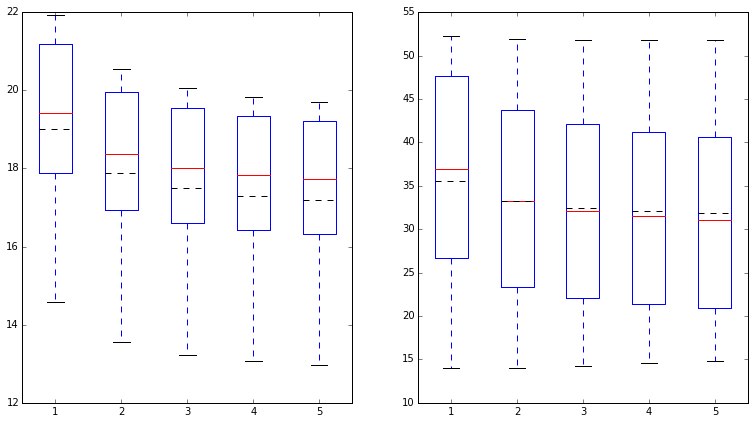

Training error: 18.1457842322
Testing error: 115.610985266
N° iterations: 5754
Beta: [ 40.97730612 -26.26603377  20.32655244 -15.10345033 -12.23326568
  40.2965877   15.18332197 -12.63207439  -9.01530236 -12.94318652
   6.49128172   8.50802687  20.73482906]
###########################################################


###########################################################
Dataset: 3
Best alpha: 0.001


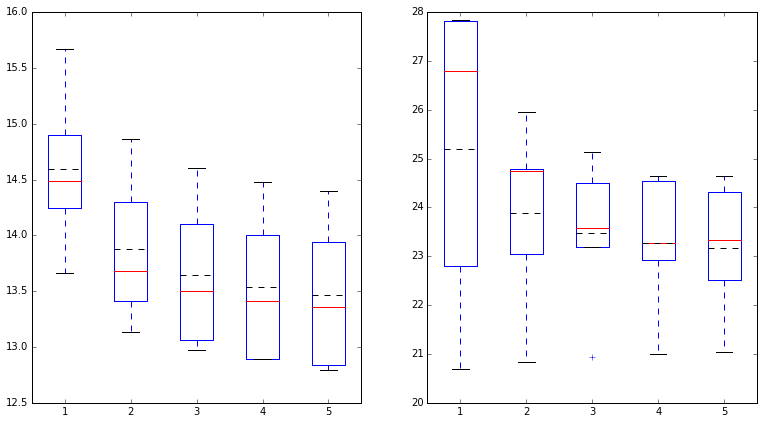

Training error: 14.1017329842
Testing error: 171.105766665
N° iterations: 5215
Beta: [ 43.47982853 -23.81054187  18.97143454 -14.94358074 -12.17779594
  40.78925657  14.30216321 -11.27322017  -6.88497476 -13.62507209
   4.77859147   5.18558864  17.3844609 ]
###########################################################


###########################################################
Dataset: 4
Best alpha: 0.001


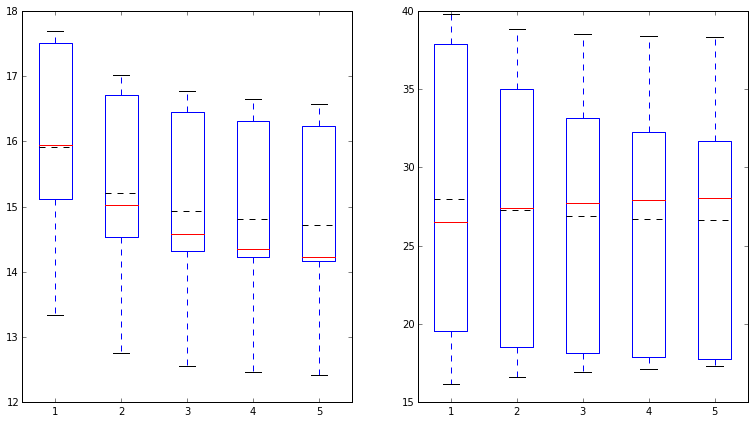

Training error: 15.5749130727
Testing error: 55.4477742699
N° iterations: 4782
Beta: [ 38.13862568 -22.8524058   19.41704046 -16.35695225 -14.1692096
  36.19605047  15.17684372 -14.74891235  -4.31813451 -13.3418267
   5.58138398  10.01687184  15.2289205 ]
###########################################################


###########################################################
Dataset: 5
Best alpha: 0.0002


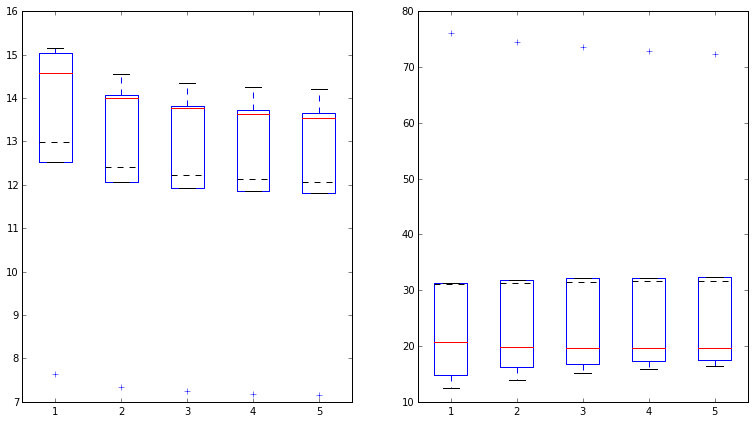

Training error: 14.2610314693
Testing error: 53.7595016258
N° iterations: 13100
Beta: [ 38.96905971 -22.3496242   18.61817791 -14.99228895 -16.47448789
  33.294526    18.74986081 -15.87213961   2.06616709 -11.27229725
   2.95665756   8.07107353  19.50895907]
###########################################################


###########################################################
Dataset: 6
Best alpha: 0.0002


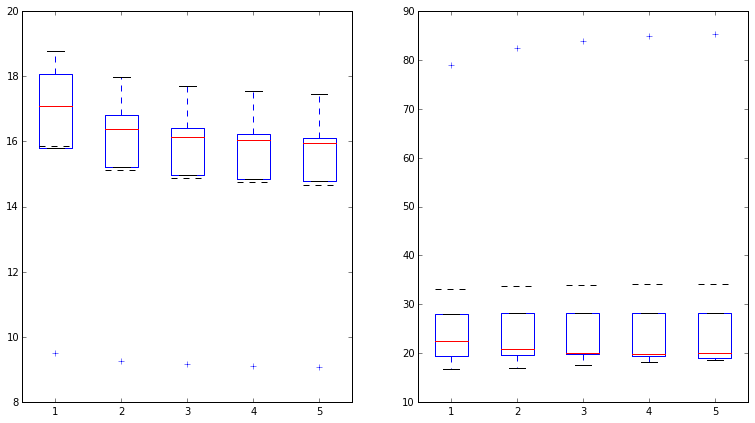

Training error: 17.0409159049
Testing error: 138.507544424
N° iterations: 11305
Beta: [ 41.70983088 -20.51953562  16.39039783 -14.08088911 -14.51329912
  29.63989364  15.73925204 -15.08751566   2.57449713 -13.14783703
   4.97107636   4.81431761  19.61171992]
###########################################################


###########################################################
Dataset: 7
Best alpha: 0.001


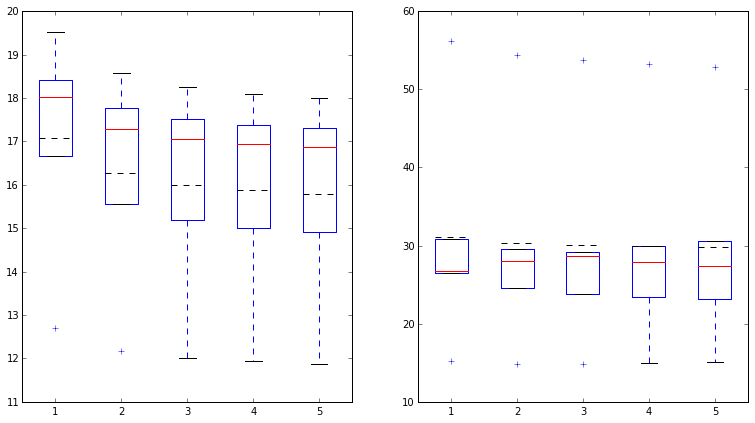

Training error: 16.7780811429
Testing error: 47.9171960704
N° iterations: 4865
Beta: [ 35.24725339 -23.12432222  19.24090643 -16.67993252 -15.71289131
  39.08325148  17.43375422 -14.25227046  -4.91821459 -13.17778673
   5.36529844  11.07718709  21.70014071]
###########################################################


###########################################################
Dataset: 8
Best alpha: 0.0004


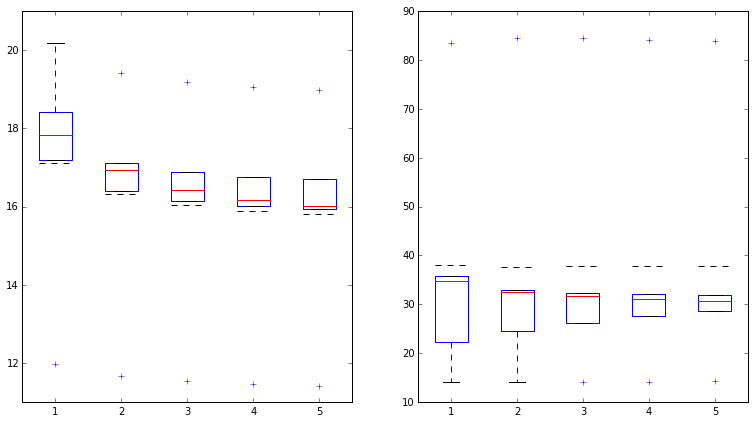

Training error: 17.6594834655
Testing error: 27.7334819973
N° iterations: 8714
Beta: [ 37.42648789 -21.9440614   17.92223893 -15.09850571 -13.9567529
  34.57936934  10.66467718 -17.44238188  -2.3707696  -12.39076294
   4.7661502   11.76878448  24.4317579 ]
###########################################################


###########################################################
Dataset: 9
Best alpha: 0.0006


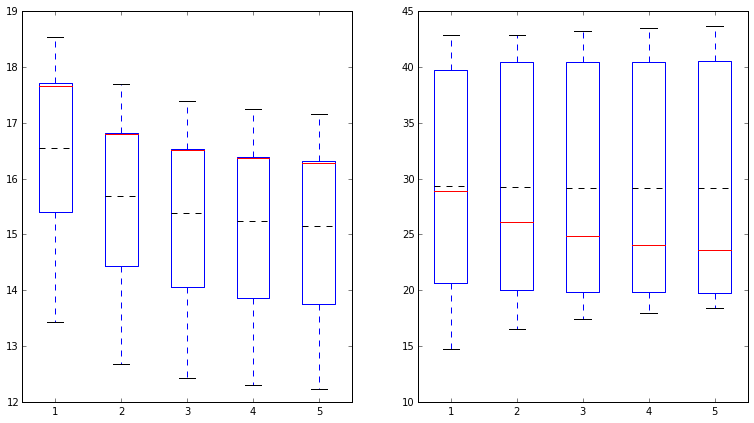

Training error: 16.3081104286
Testing error: 337.991435488
N° iterations: 7331
Beta: [ 36.07809829 -23.34706011  21.82703513 -16.90253197 -14.50602867
  30.50461255  15.59067892 -14.39360658 -10.69501581 -14.76462896
   5.72860295  12.19735217  20.68295466]
###########################################################


###########################################################
Dataset: 10
Best alpha: 0.001


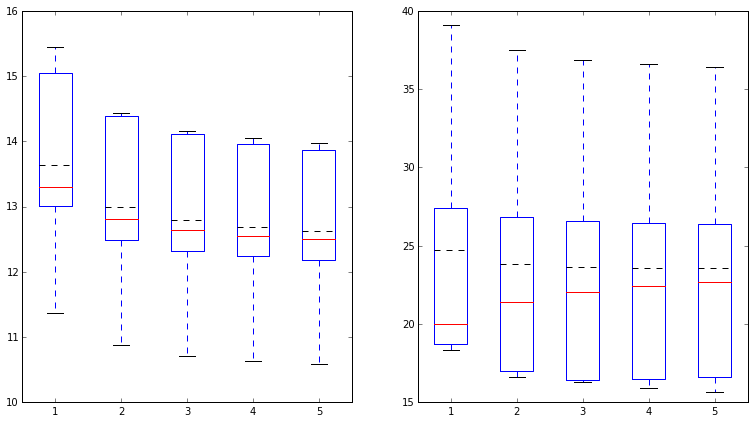

Training error: 13.4248859313
Testing error: 76.0132818686
N° iterations: 4895
Beta: [ 42.5434952  -21.13316114  21.98088829 -15.69155676 -15.44222201
  35.89580294  16.58903568 -13.43732599  -4.50854314 -10.56698216
   3.68367618   3.3306186   18.37652304]
###########################################################


###########################################################
Dataset: 11
Best alpha: 0.0002


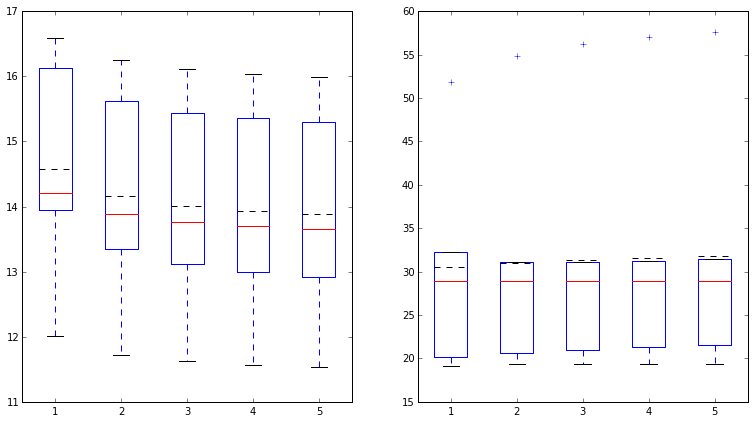

Training error: 15.8168112322
Testing error: 29.6423010367
N° iterations: 9607
Beta: [ 42.78315122 -21.42344317  18.90715836 -20.04294434 -13.2358552
  20.77143974  11.83444716 -15.35479563   0.08628419 -13.37862242
   4.28844871   9.81112513  19.07971477]
###########################################################


###########################################################
Dataset: 12
Best alpha: 0.0004


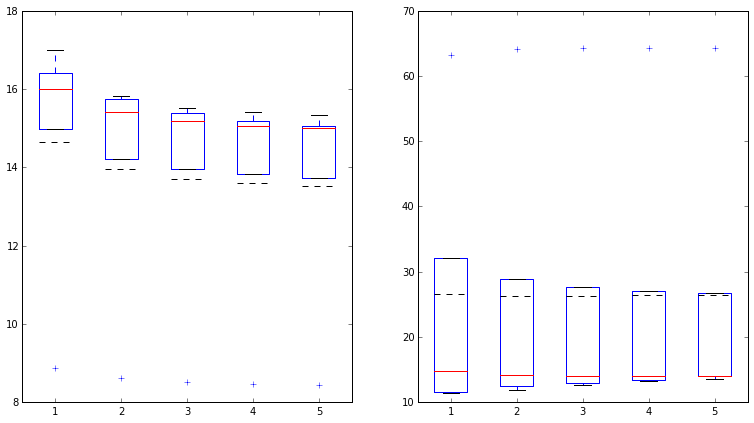

Training error: 14.7897334494
Testing error: 79.6061371602
N° iterations: 8756
Beta: [ 40.66170122 -23.03617014  17.83509579 -17.49820924 -14.65334601
  31.24612974  12.5497103  -17.15826607  -0.68050394  -8.31055737
   3.77579986  12.55725252  19.39283189]
###########################################################


###########################################################
Dataset: 13
Best alpha: 0.001


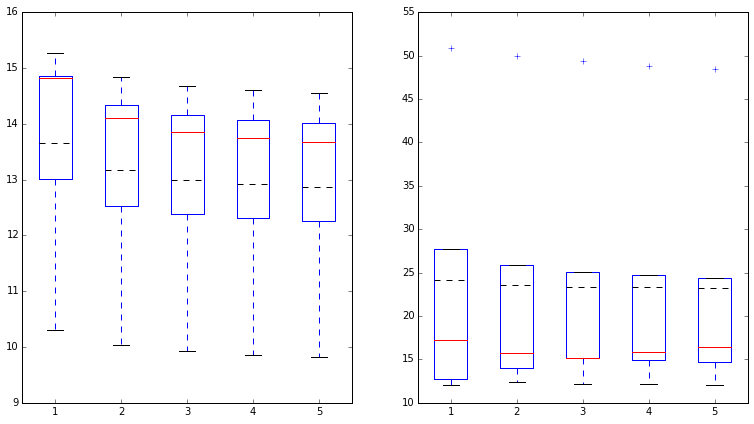

Training error: 13.5218597059
Testing error: 246.084167693
N° iterations: 4208
Beta: [ 39.03918344 -25.42444857  15.04479934 -14.00107694 -14.79234579
  28.6564351   13.8848172  -19.19484891  -5.21978877 -12.58570322
   5.25564017  13.45444692  25.19615693]
###########################################################


###########################################################
Dataset: 14
Best alpha: 0.0004


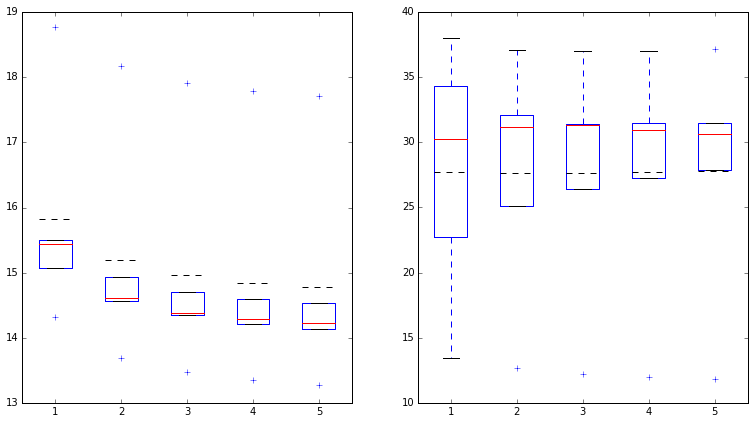

Training error: 16.0666898014
Testing error: 117.196223122
N° iterations: 7069
Beta: [ 34.73242323 -22.10504461  19.13642107 -17.57468323 -12.91483417
  24.70000691  16.79789533 -12.87150976  -0.28195429  -9.29053417
   4.82209831   7.73622924  21.85011054]
###########################################################


###########################################################
Dataset: 15
Best alpha: 0.001


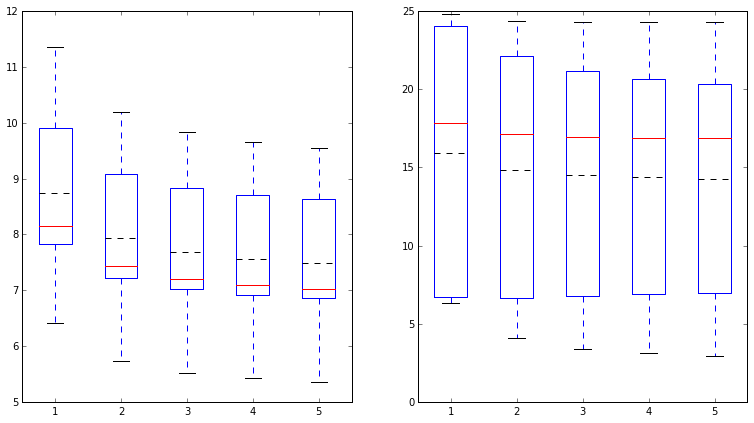

Training error: 7.96105164535
Testing error: 102.779537282
N° iterations: 8665
Beta: [ 49.03295931 -13.977522    17.61870346 -18.44610692 -13.4755449
  43.5616765   11.10390151 -19.2063919  -10.86015377  -6.45306249
   2.4884307    3.70092436   4.68954867]
###########################################################


###########################################################
Dataset: 16
Best alpha: 0.001


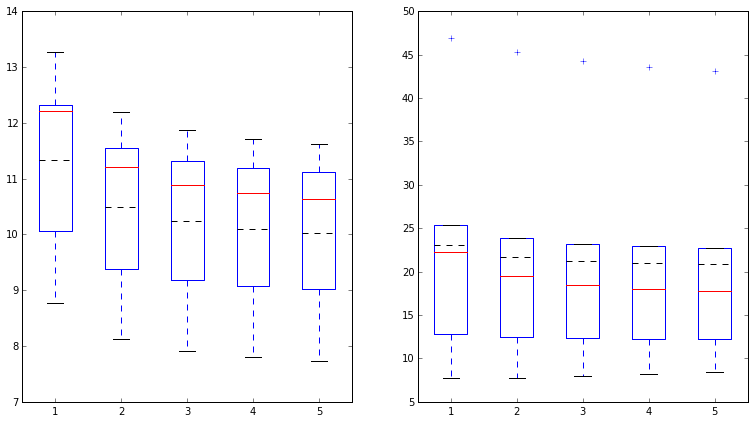

Training error: 10.6974314356
Testing error: 509.388015464
N° iterations: 7349
Beta: [ 38.46720962 -24.62821952  21.09077848 -16.50926549 -14.38527414
  42.70979748  16.51791103 -13.16249586 -10.81589923 -10.3028068
   3.98293763  11.99953081  19.99351146]
###########################################################


###########################################################
Dataset: 17
Best alpha: 0.001


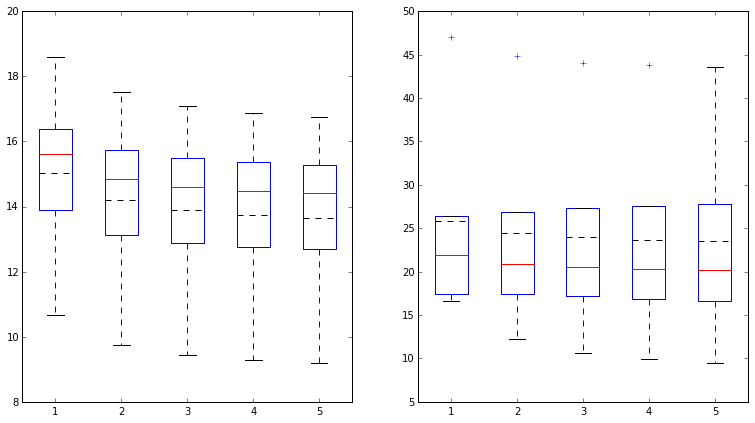

Training error: 14.3023622226
Testing error: 72.9172185356
N° iterations: 5337
Beta: [ 42.47136368 -22.96164866  19.89721547 -12.74344918 -13.39477061
  36.11799981  14.4465576  -13.38551719  -4.56301128 -13.5879567
   4.74349268   7.00580626  18.3825284 ]
###########################################################


###########################################################
Dataset: 18
Best alpha: 0.001


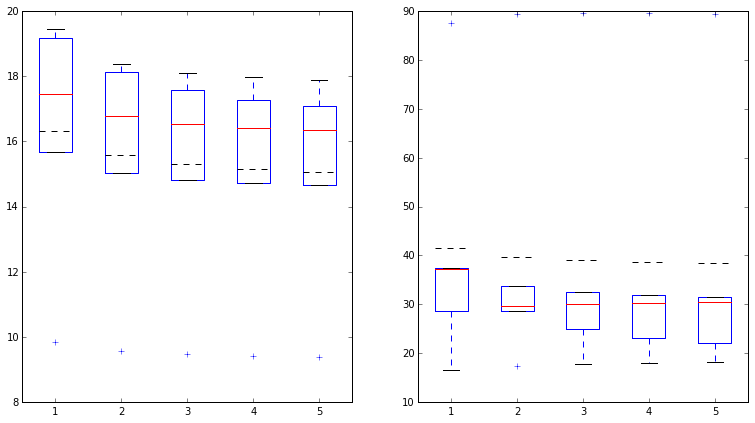

Training error: 16.4039458304
Testing error: 101.716074157
N° iterations: 4981
Beta: [ 41.6826372  -23.14865566  18.04465529 -16.13808303 -12.64264225
  39.99834988  14.96571734 -12.93775712  -6.2268374  -12.74674133
   5.67665948   6.40183894  18.60261297]
###########################################################


###########################################################
Dataset: 19
Best alpha: 0.0004


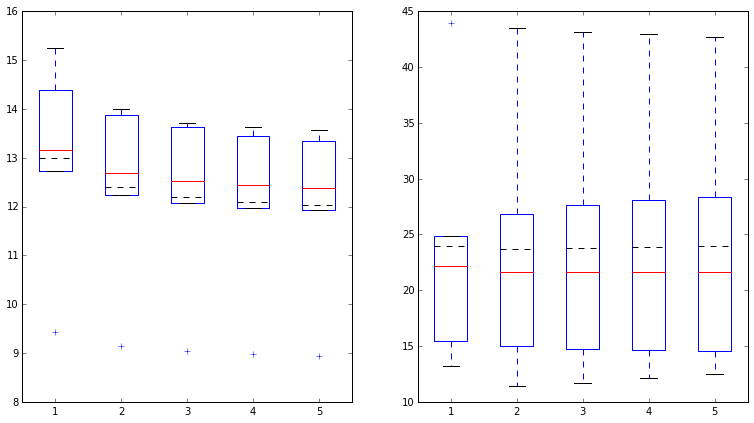

Training error: 13.1956721947
Testing error: 79.6597927613
N° iterations: 8863
Beta: [ 41.63488855 -20.52358041  17.59161829 -15.95919783 -13.44273995
  33.85212038  11.4521146  -16.65381385  -3.90272127  -9.81863875
   4.54018838  10.42277224  12.00998365]
###########################################################




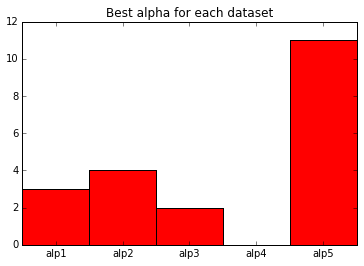

In [49]:
solve_all(gd_batch, params=params1, data_func=rescale)

### Gradient descent batch for normalized data

###########################################################
Dataset: 0
Best alpha: 0.0002


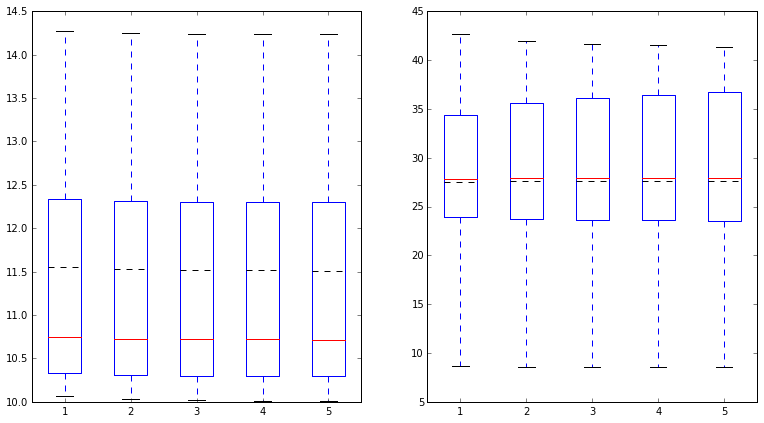

Training error: 12.7266740348
Testing error: 38.4079585793
N° iterations: 1535
Beta: [ 42.22724     -4.04315611   4.26533185  -3.44623502  -3.92100029
   7.94102272   3.2702556   -4.1383568   -1.97993514  -3.21326375
   2.34548981   1.78377407   3.69012969]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.0002


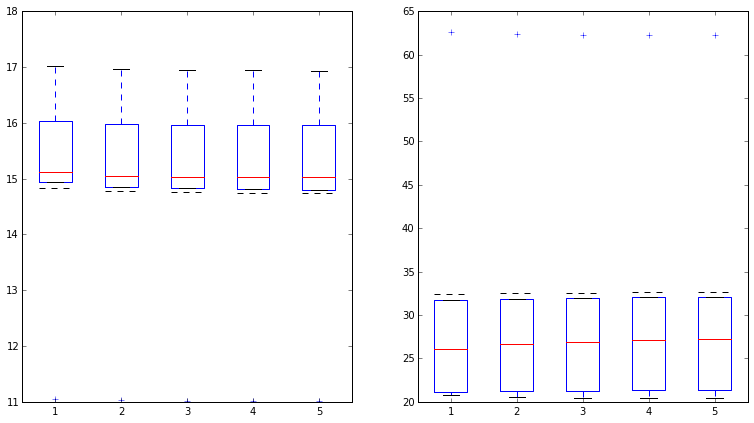

Training error: 16.0715344155
Testing error: 65.1941175822
N° iterations: 1897
Beta: [ 43.83778667  -4.66430519   4.32313969  -3.2124935   -3.14395908
   7.50054076   2.84675912  -3.45460573  -1.87703206  -2.3225976
   1.84182202   1.79539497   3.46750775]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.001


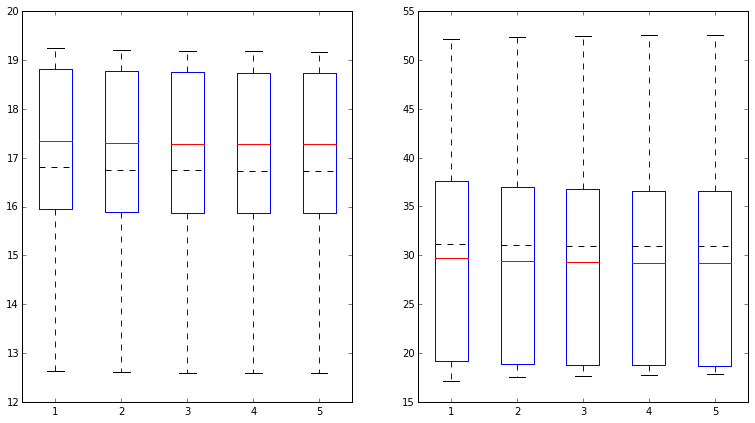

Training error: 17.7788520385
Testing error: 18.2024811924
N° iterations: 485
Beta: [ 42.41314667  -4.47172873   4.69814762  -3.18592618  -3.26956741
   8.32026521   3.10969724  -3.16872746  -3.04440902  -3.11591235
   2.99825766   1.69255389   3.66733914]
###########################################################


###########################################################
Dataset: 3
Best alpha: 0.0002


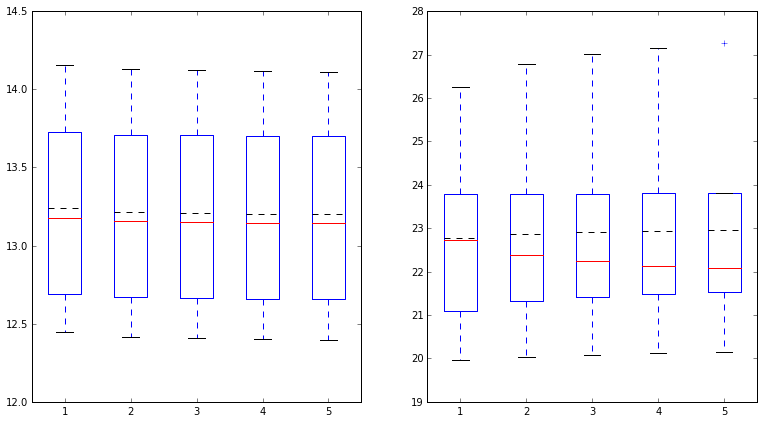

Training error: 13.9377761345
Testing error: 48.6525469488
N° iterations: 1203
Beta: [ 43.11717279  -4.47464154   4.35683157  -3.15153493  -3.3965321
   6.59515551   3.27512567  -2.92834692  -1.79515558  -3.28448074
   2.09995663   0.88652413   2.66022111]
###########################################################


###########################################################
Dataset: 4
Best alpha: 0.0002


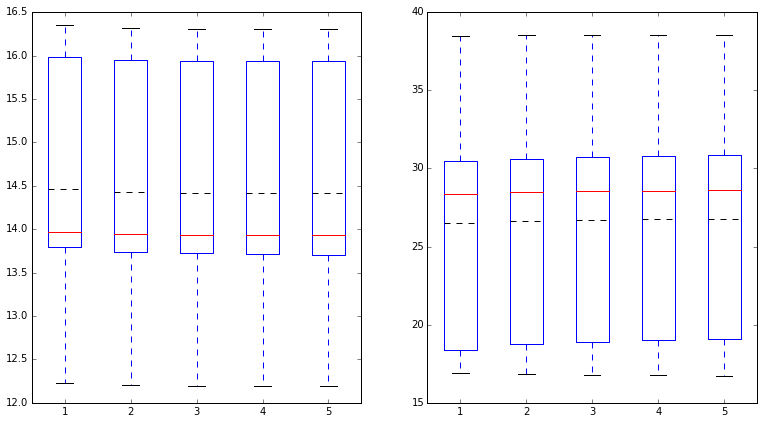

Training error: 15.3894271276
Testing error: 24.1581873664
N° iterations: 1429
Beta: [ 42.22333332  -4.4092344    4.34356126  -3.3012791   -3.46030416
   7.15808906   2.74896063  -3.54196747  -1.47858574  -2.95093284
   2.45283814   1.64211508   2.80813224]
###########################################################


###########################################################
Dataset: 5
Best alpha: 0.0002


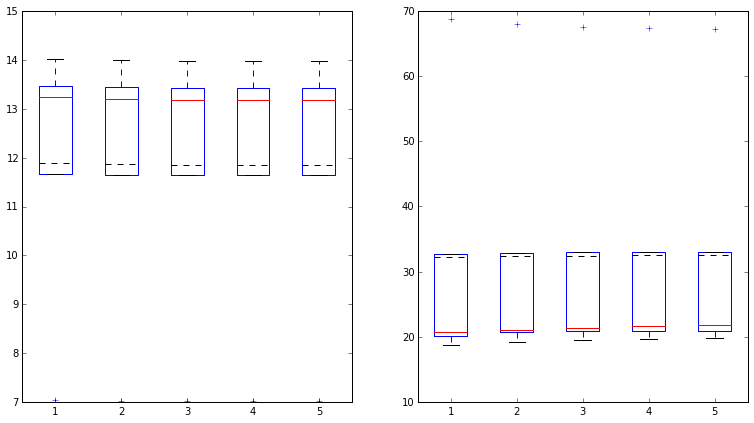

Training error: 13.3703648326
Testing error: 27.1554482493
N° iterations: 1263
Beta: [ 41.80137312  -4.39506149   4.17481775  -2.85725637  -3.94581553
   7.10316274   3.57486583  -3.68668924  -0.82935852  -2.64027829
   1.5479853    1.48896418   3.21502106]
###########################################################


###########################################################
Dataset: 6
Best alpha: 0.001


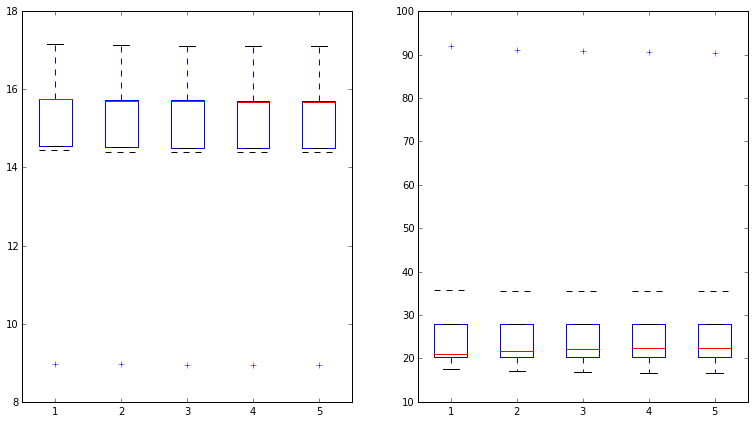

Training error: 15.7806050056
Testing error: 50.1360687667
N° iterations: 379
Beta: [ 43.19453333  -4.55099884   4.00533916  -2.42811103  -3.53478696
   7.34380252   3.02588211  -3.66421704  -1.40322796  -3.16490312
   2.47981801   1.3434567    3.36077348]
###########################################################


###########################################################
Dataset: 7
Best alpha: 0.0002


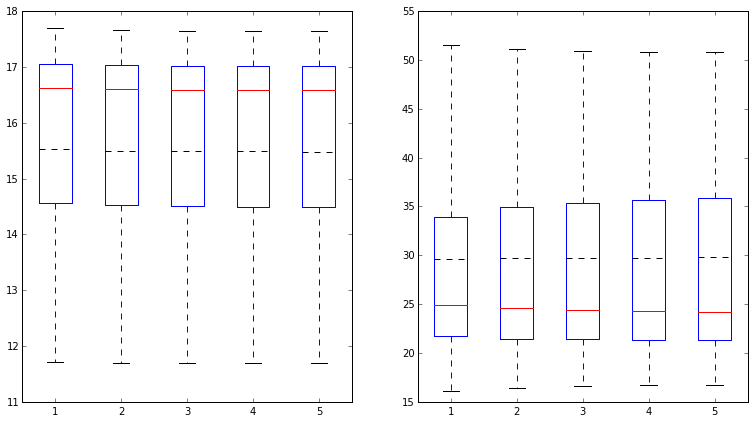

Training error: 16.5841191369
Testing error: 28.077556808
N° iterations: 1367
Beta: [ 42.58398662  -4.28888244   4.54616723  -3.62229033  -4.01611937
   7.51142511   3.00496778  -3.35166135  -1.57069433  -2.79528008
   2.41798063   1.99008375   3.72507089]
###########################################################


###########################################################
Dataset: 8
Best alpha: 0.0002


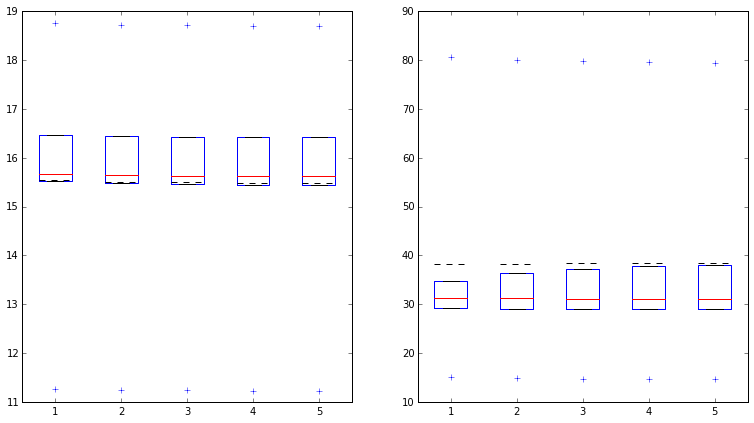

Training error: 17.0797580788
Testing error: 18.6923467845
N° iterations: 1403
Beta: [ 41.40637331  -4.00884774   4.08740679  -2.94931446  -3.52231715
   7.38863638   2.591044    -4.3828369   -1.56511933  -3.04335534
   2.17415141   2.33909849   4.04414028]
###########################################################


###########################################################
Dataset: 9
Best alpha: 0.0002


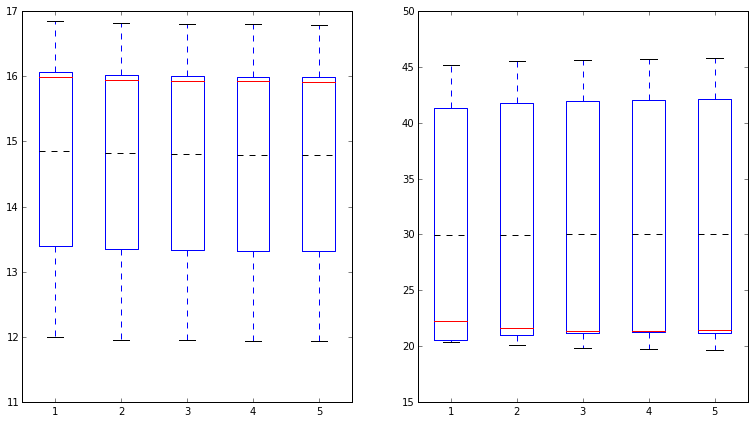

Training error: 15.8926108555
Testing error: 32.4322681958
N° iterations: 1875
Beta: [ 41.79716     -4.26922875   5.09343193  -3.58302301  -3.78270513
   7.61725877   2.90182797  -3.80030809  -3.26869871  -3.34650194
   2.63304474   2.40970524   3.71457711]
###########################################################


###########################################################
Dataset: 10
Best alpha: 0.0002


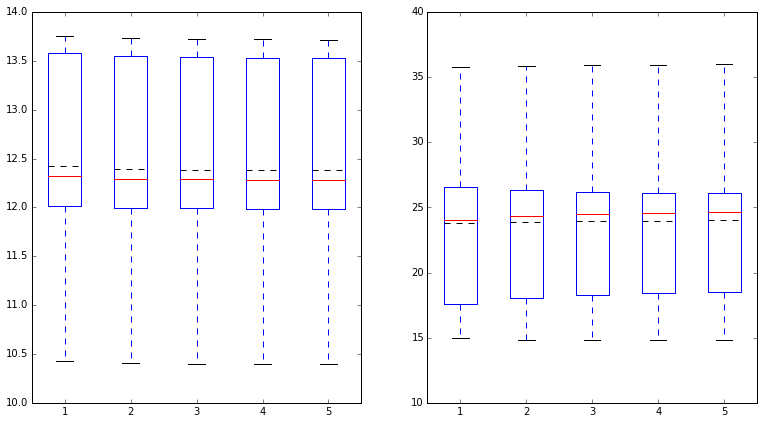

Training error: 13.2809364772
Testing error: 51.964392846
N° iterations: 1348
Beta: [ 43.12089327  -3.91445738   4.88977556  -2.88497312  -3.52008254
   7.00679403   2.98855587  -3.55531901  -1.36892297  -2.34585116
   1.60257793   0.7766664    2.97295963]
###########################################################


###########################################################
Dataset: 11
Best alpha: 0.0002


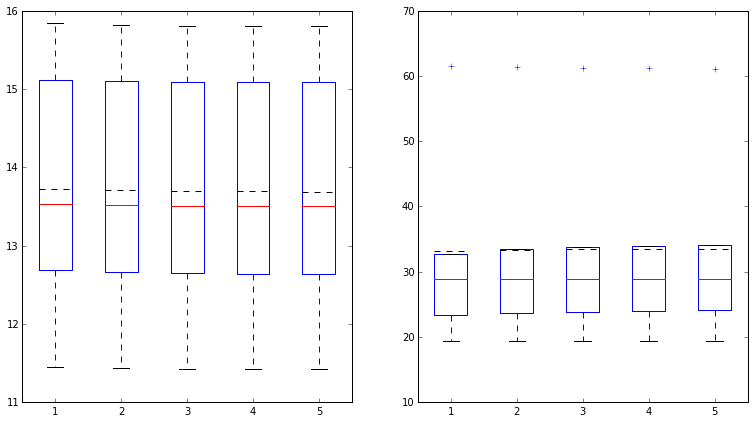

Training error: 15.1229661239
Testing error: 58.2778323768
N° iterations: 1094
Beta: [ 40.59829066  -4.13029944   4.12549039  -3.91258229  -3.35396442
   5.02685685   2.51194793  -3.88477033  -0.86672198  -2.98968259
   1.91552092   2.17620455   2.9309228 ]
###########################################################


###########################################################
Dataset: 12
Best alpha: 0.0002


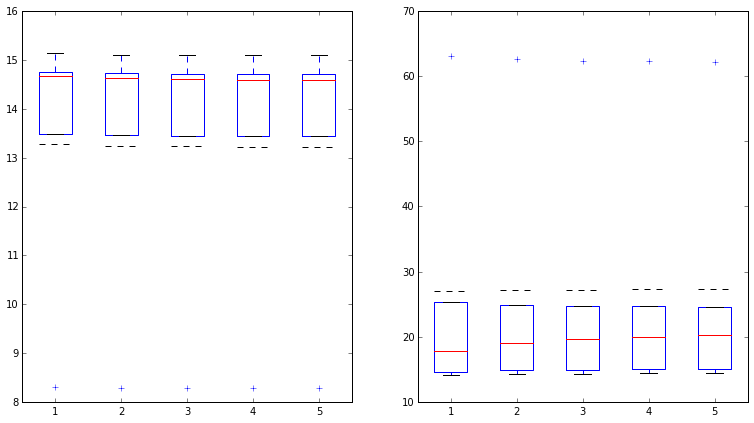

Training error: 14.2704574864
Testing error: 33.4736955049
N° iterations: 1489
Beta: [ 42.77134666  -4.19268165   3.73253299  -3.57369981  -3.68015717
   6.87015278   2.17608844  -4.37087821  -1.22942989  -1.91536645
   1.81116495   2.43808041   3.40614342]
###########################################################


###########################################################
Dataset: 13
Best alpha: 0.0006


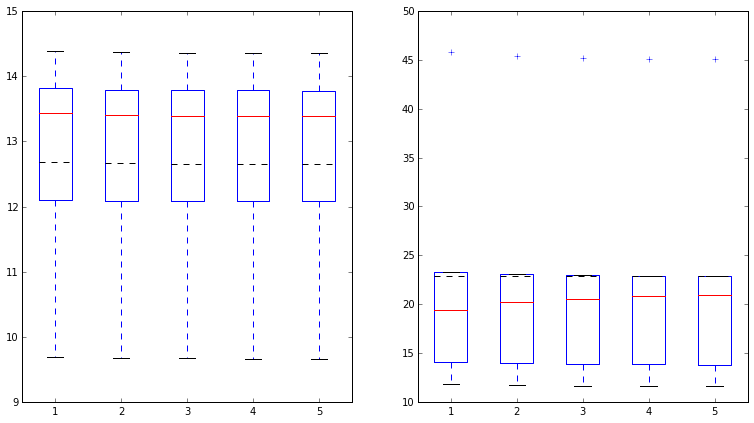

Training error: 13.3686890914
Testing error: 49.4021401471
N° iterations: 510
Beta: [ 42.50937333  -4.46086979   3.44498257  -2.5510803   -3.74231756
   6.72429409   2.24538682  -4.78063591  -1.48039531  -3.17631813
   2.31424334   2.41344332   4.31689767]
###########################################################


###########################################################
Dataset: 14
Best alpha: 0.0002


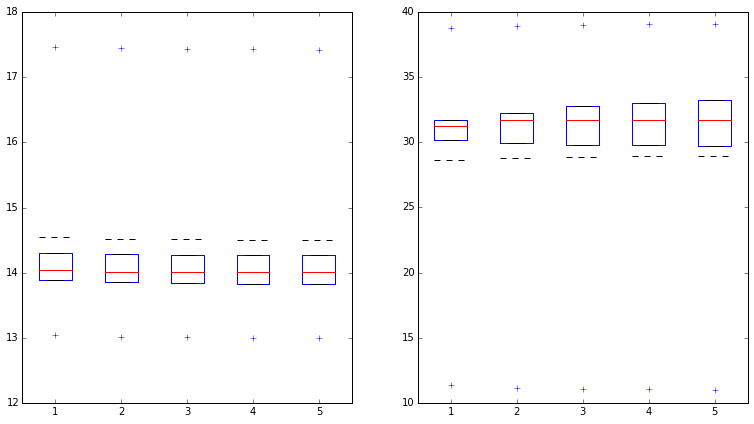

Training error: 15.5571989603
Testing error: 62.1502546032
N° iterations: 1247
Beta: [ 40.89617307  -4.41645044   4.65591513  -3.24699131  -3.01341205
   6.15241167   3.18925751  -3.01318514  -0.7306811   -1.94002047
   2.23849568   1.67650332   3.7519758 ]
###########################################################


###########################################################
Dataset: 15
Best alpha: 0.0002


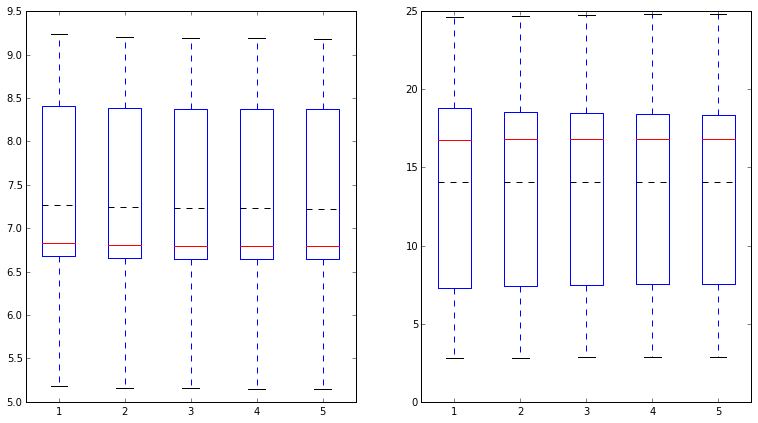

Training error: 7.7831599526
Testing error: 103.539701305
N° iterations: 2418
Beta: [ 42.47049333  -2.16743978   3.95379796  -3.6437795   -3.34902027
   8.32182208   1.72541111  -4.85992061  -3.09280853  -1.05674451
   1.0511798    0.68664537   0.87871878]
###########################################################


###########################################################
Dataset: 16
Best alpha: 0.001


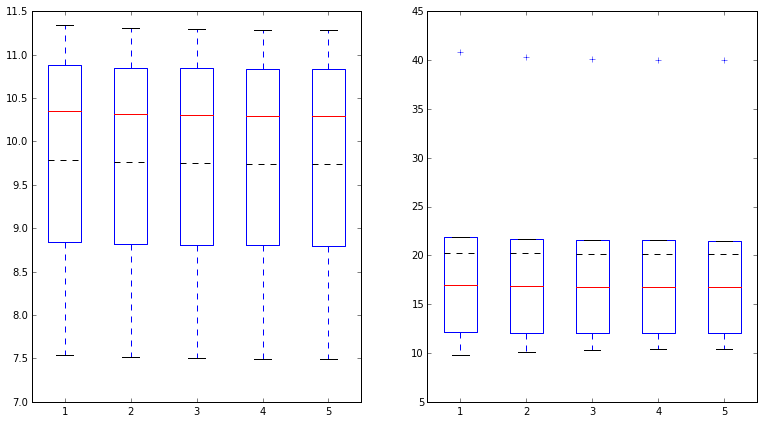

Training error: 10.4686233286
Testing error: 79.8182740031
N° iterations: 611
Beta: [ 43.07214667  -4.52936459   4.94480033  -2.9628303   -3.72101936
   9.0866287    2.57665021  -3.61498414  -3.47327674  -1.90466769
   1.7759778    2.30181467   3.36992567]
###########################################################


###########################################################
Dataset: 17
Best alpha: 0.0004


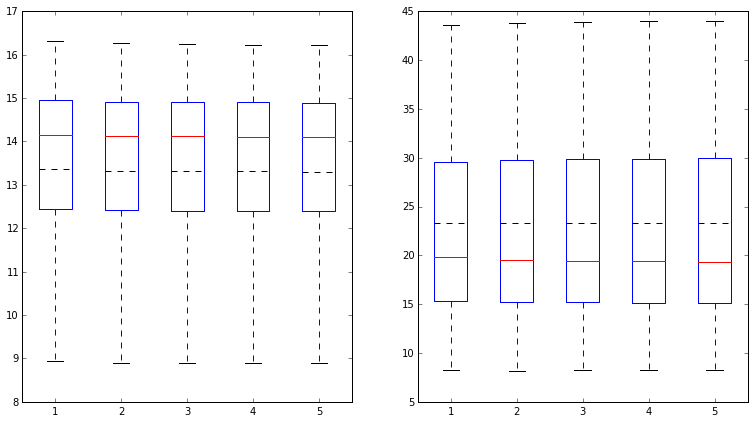

Training error: 14.0575024157
Testing error: 39.4462557317
N° iterations: 864
Beta: [ 42.70348     -4.73154876   4.6189854   -2.12763511  -3.33441176
   6.90125957   2.6170522   -3.50309675  -1.66047681  -2.91769669
   1.99469464   1.32792442   3.13403565]
###########################################################


###########################################################
Dataset: 18
Best alpha: 0.001


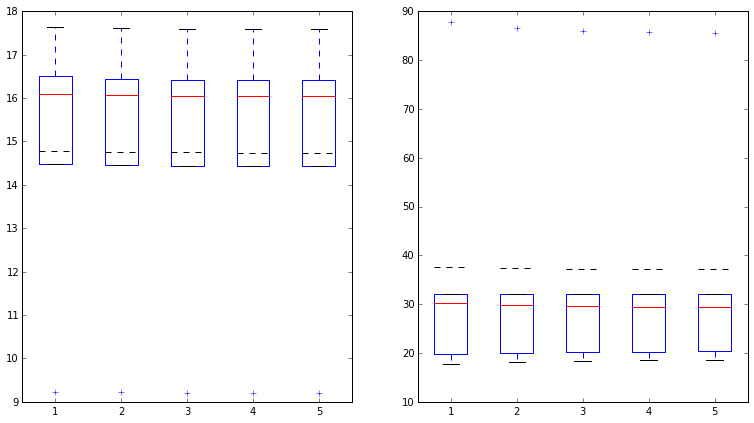

Training error: 16.1738495233
Testing error: 19.219045776
N° iterations: 323
Beta: [ 42.40008     -4.07718548   4.25235923  -3.49537098  -3.10156829
   7.34537652   3.23673607  -2.81520373  -1.91696785  -2.69105263
   2.50975743   0.92039433   3.09377533]
###########################################################


###########################################################
Dataset: 19
Best alpha: 0.001


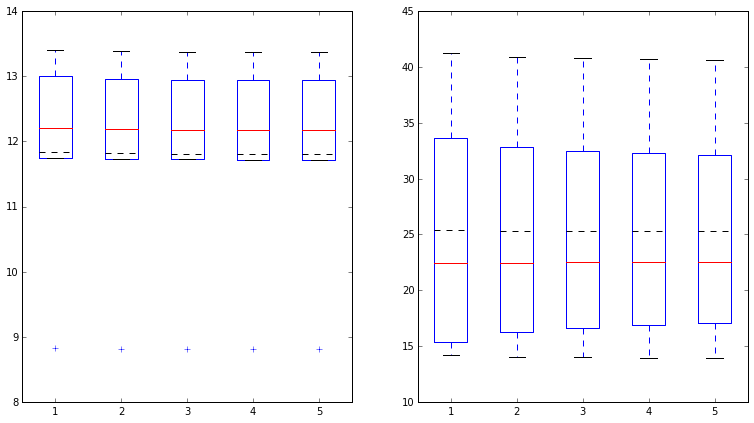

Training error: 12.7453067041
Testing error: 41.4905102572
N° iterations: 382
Beta: [ 42.15890667  -3.83045019   4.30209724  -2.74105279  -2.99493926
   7.40650418   2.00820488  -4.30750285  -2.0370021   -2.28008578
   2.14499976   2.04376586   2.64868626]
###########################################################




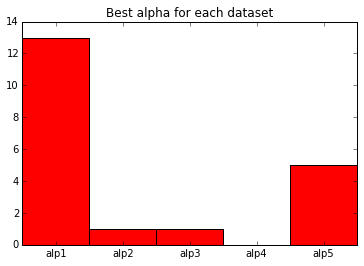

In [50]:
solve_all(gd_batch, params=params1, data_func=normalize)

### Gradient descent online for raw data

###########################################################
Dataset: 0
Best alpha: 4.5e-07


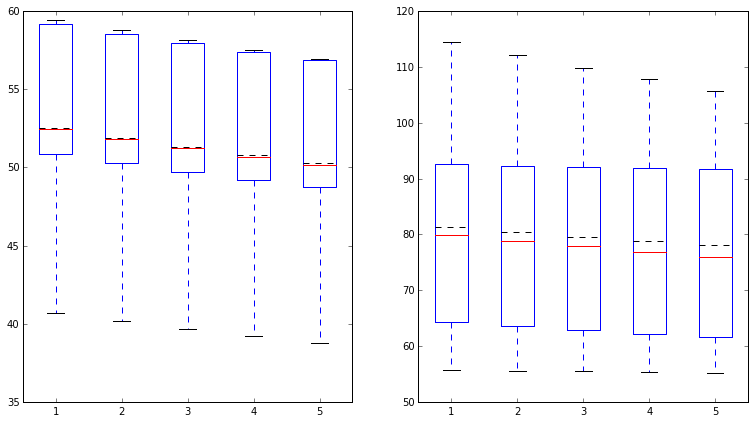

Training error: 47.893692584
Testing error: 92.0966603914
N° iterations: 41750
Beta: [ 1.44743538 -0.07561652  3.75762753 -3.18374354 -0.05915529  3.49252504
  2.63832438  0.01618509 -0.01063685 -0.13032407  3.33221125  0.82855592
  1.60927934]
###########################################################


###########################################################
Dataset: 1
Best alpha: 4.5e-07


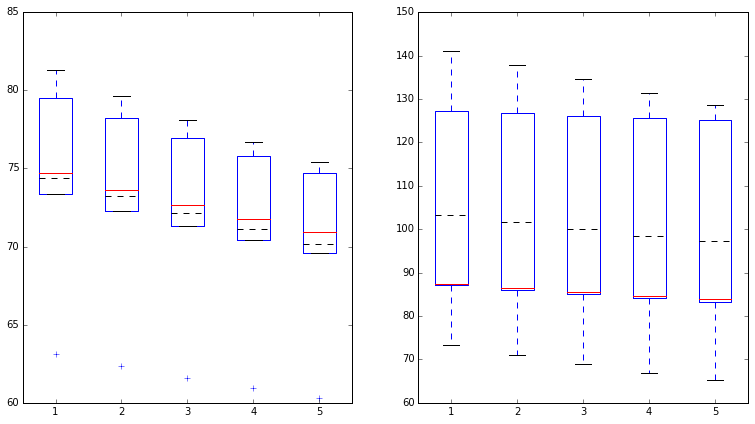

Training error: 64.6988609429
Testing error: 47.9123694862
N° iterations: 37329
Beta: [ 1.53626613 -0.13388669  3.82033968 -2.33312892 -0.03380505  2.63560128
  2.5623219   0.11577888  0.02850083 -0.12688781  2.7556189   0.7880256
  1.59184366]
###########################################################


###########################################################
Dataset: 2
Best alpha: 4.5e-07


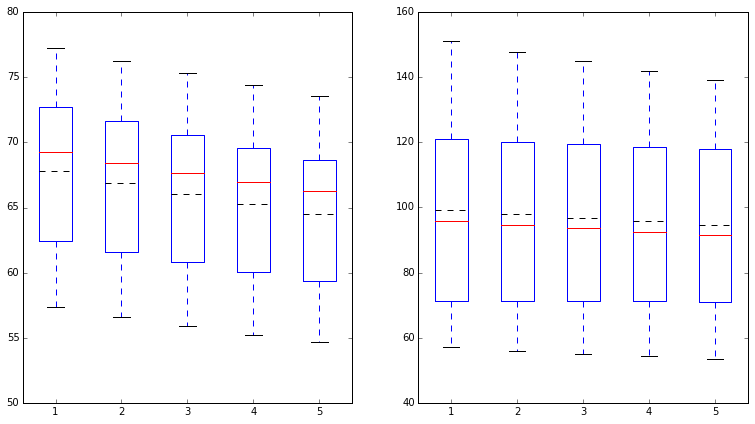

Training error: 60.9392772213
Testing error: 78.1358655876
N° iterations: 35248
Beta: [ 1.18251957 -0.13932677  3.77905972 -1.78536305 -0.03231867  2.56250732
  2.71625579  0.14680593  0.02130223 -0.13164147  2.2851568   0.68674787
  1.33404164]
###########################################################


###########################################################
Dataset: 3
Best alpha: 4.5e-07


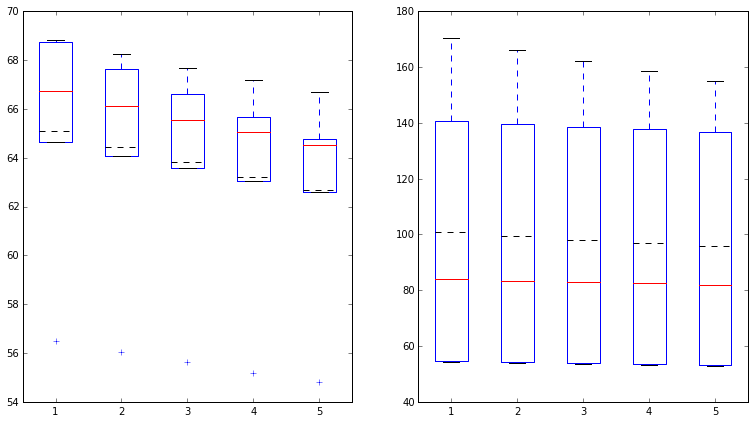

Training error: 58.9787768796
Testing error: 99.2667062665
N° iterations: 33095
Beta: [  1.25206878e+00  -1.89620806e-03   3.02982280e+00  -2.89611308e+00
  -4.39751522e-02   3.53022599e+00   2.54892401e+00  -3.29043001e-01
  -3.68449141e-03  -1.66866736e-01   1.88158381e+00   5.76212999e-01
   1.45492457e+00]
###########################################################


###########################################################
Dataset: 4
Best alpha: 4.5e-07


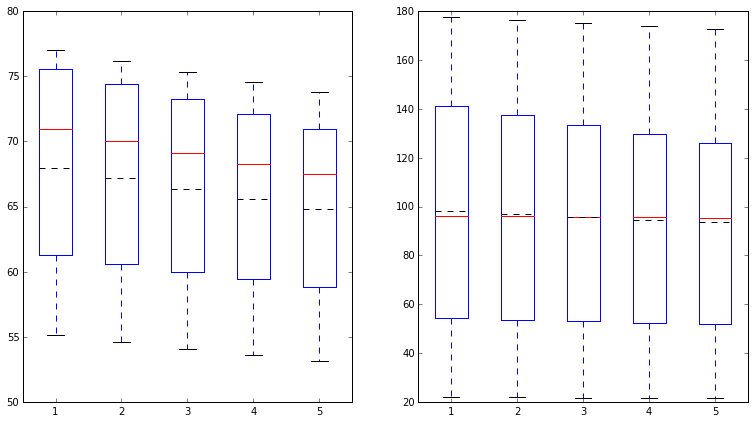

Training error: 60.1774212144
Testing error: 88.333392035
N° iterations: 34004
Beta: [ 1.25926266 -0.08470911  2.6711714  -2.15828444 -0.03770772  2.98693522
  2.71485743 -0.17183525  0.02176195 -0.14955892  2.72646379  0.84175317
  1.22758894]
###########################################################


###########################################################
Dataset: 5
Best alpha: 4.5e-07


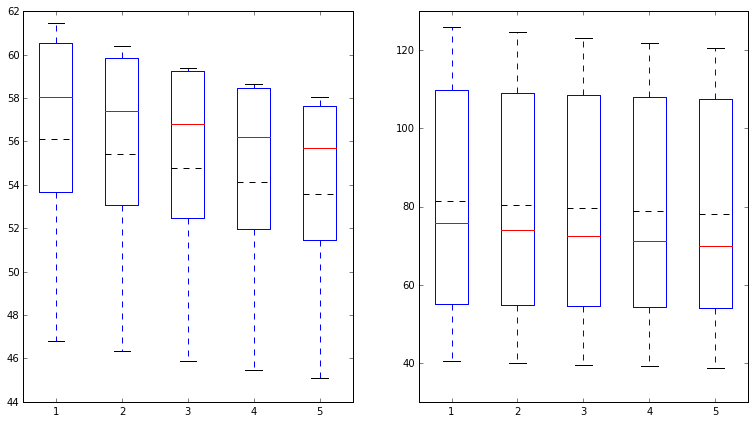

Training error: 51.0422341216
Testing error: 103.788709289
N° iterations: 37143
Beta: [ 1.21539441 -0.08267009  3.79205287 -2.48480545 -0.04397533  3.15474001
  2.54192557 -0.02431845  0.02284006 -0.11381089  1.97611921  0.80645943
  1.26132417]
###########################################################


###########################################################
Dataset: 6
Best alpha: 4.5e-07


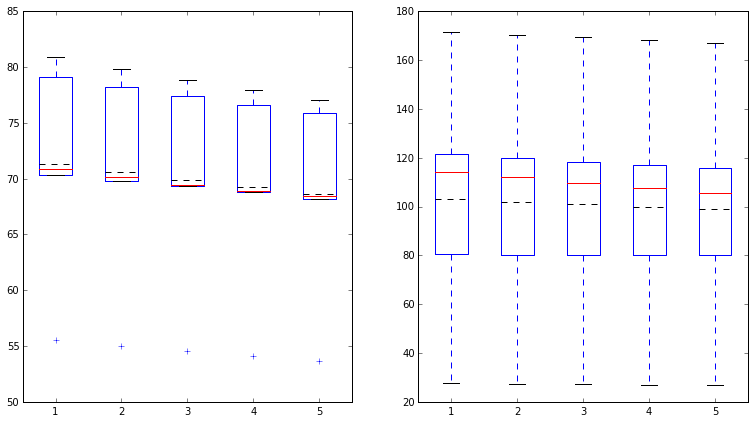

Training error: 65.5165575721
Testing error: 57.4194579169
N° iterations: 32605
Beta: [ 1.28417337 -0.03695487  3.42048348 -2.59660338 -0.02958655  3.06371816
  2.30863764 -0.29869789  0.0135869  -0.1527558   2.23174123  0.69981678
  1.35099217]
###########################################################


###########################################################
Dataset: 7
Best alpha: 4.5e-07


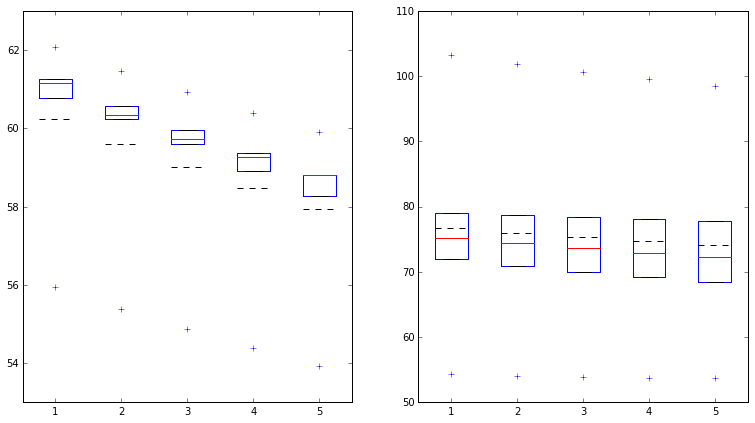

Training error: 55.3588268682
Testing error: 75.6410018834
N° iterations: 36759
Beta: [ 1.29291884 -0.08425586  4.02304359 -2.84100515 -0.04304318  3.27646333
  2.50542931  0.08427929  0.01499121 -0.14522955  2.26011666  0.76458635
  1.47748532]
###########################################################


###########################################################
Dataset: 8
Best alpha: 4.5e-07


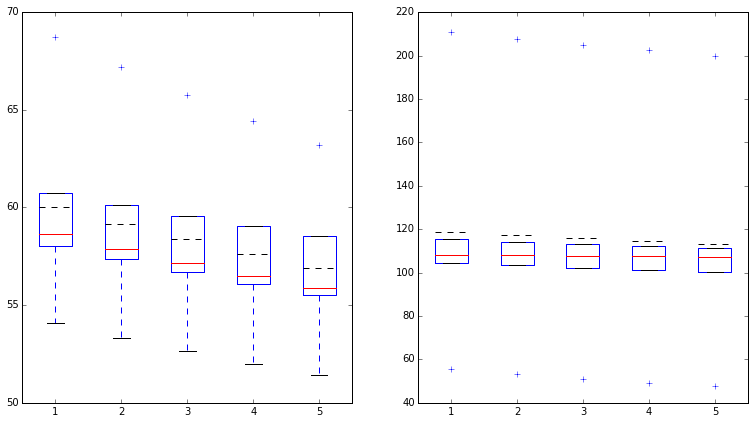

Training error: 54.6439352519
Testing error: 80.7421944912
N° iterations: 38811
Beta: [ 1.25268011 -0.07141425  3.30144822 -2.75083619 -0.05302154  3.0322892
  2.56755723  0.01452737  0.00406663 -0.12639362  3.13545931  0.80757765
  1.59615171]
###########################################################


###########################################################
Dataset: 9
Best alpha: 4.5e-07


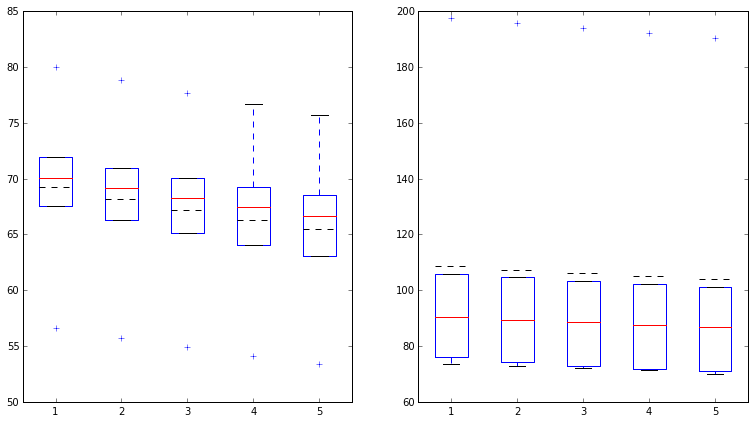

Training error: 62.1799637644
Testing error: 58.8581361381
N° iterations: 38345
Beta: [ 1.47312936 -0.10731742  4.08570372 -2.34308771 -0.03932238  2.30371831
  2.58940462  0.09211306  0.01573669 -0.15238699  2.77692147  0.84339576
  1.5441139 ]
###########################################################


###########################################################
Dataset: 10
Best alpha: 4.5e-07


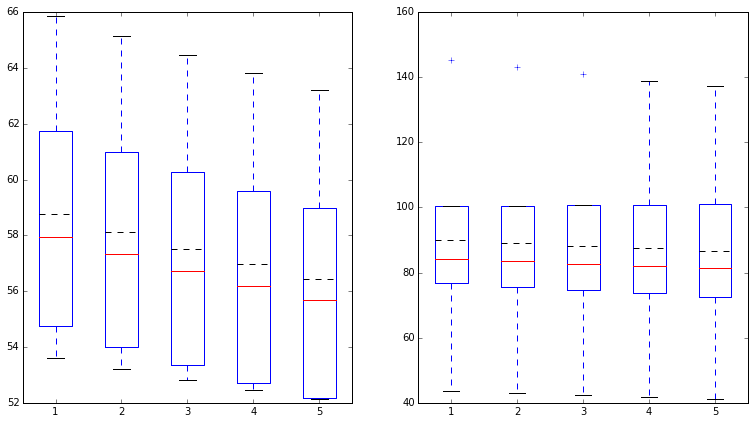

Training error: 54.2693780177
Testing error: 102.231247534
N° iterations: 35610
Beta: [ 1.18461049 -0.03684129  3.96485816 -2.63204925 -0.03037182  3.14577045
  2.17580241 -0.24617977  0.00804431 -0.08475944  1.49531614  0.74911355
  1.25305545]
###########################################################


###########################################################
Dataset: 11
Best alpha: 4.5e-07


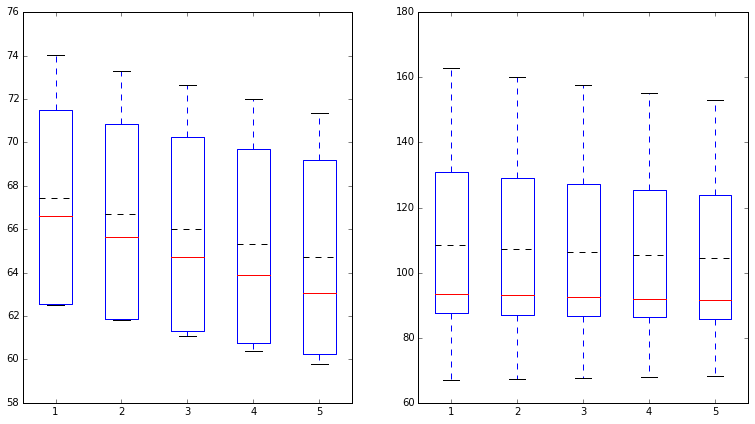

Training error: 62.2595665841
Testing error: 86.3623966795
N° iterations: 33268
Beta: [ 1.12083941 -0.05200821  3.69009893 -2.54714712 -0.04461818  2.49044479
  2.48235786  0.064489    0.00419881 -0.13161082  1.93142304  0.667815
  1.34926379]
###########################################################


###########################################################
Dataset: 12
Best alpha: 4.5e-07


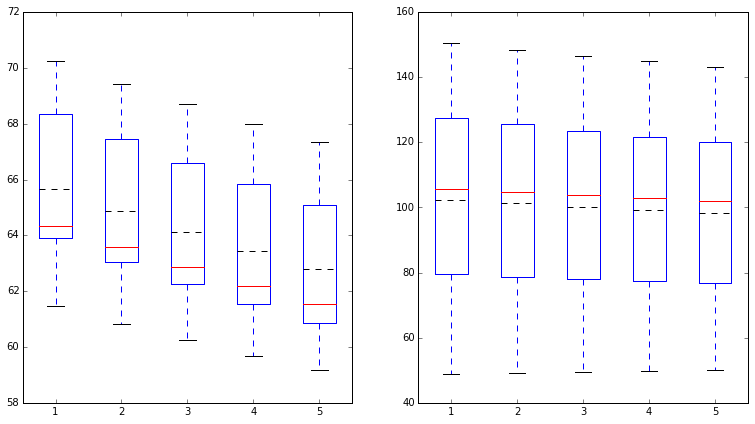

Training error: 60.2843606249
Testing error: 48.357913035
N° iterations: 38804
Beta: [ 1.47154514 -0.08893831  4.28096495 -2.82948898 -0.03613701  2.92469462
  2.30982756  0.06525828  0.01026233 -0.10311901  2.95842378  0.79396935
  1.75802215]
###########################################################


###########################################################
Dataset: 13
Best alpha: 4.5e-07


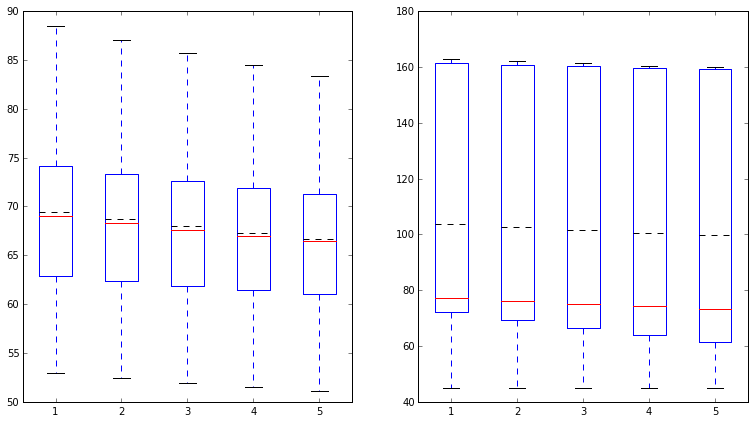

Training error: 63.2651920301
Testing error: 53.681043548
N° iterations: 34360
Beta: [ 1.26225314 -0.06935303  3.72624955 -2.84690134 -0.04642001  2.91673681
  2.4754487  -0.01698243  0.0169179  -0.1278096   2.24140598  0.68847281
  1.59441584]
###########################################################


###########################################################
Dataset: 14
Best alpha: 4.5e-07


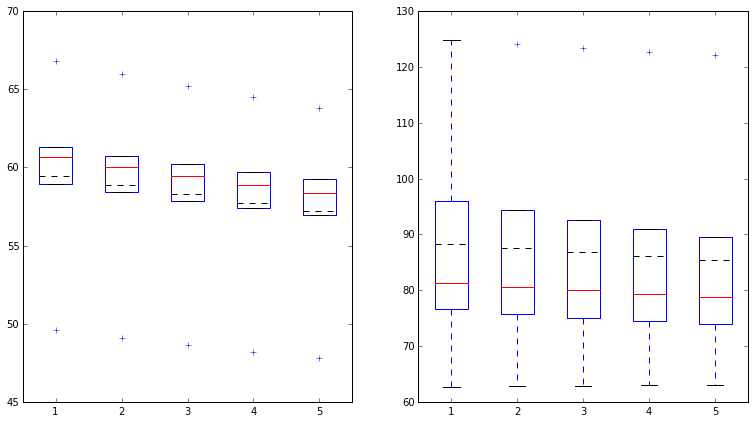

Training error: 55.8103948422
Testing error: 90.6429254352
N° iterations: 35905
Beta: [ 1.2456976  -0.06302368  4.25706545 -2.80026583 -0.03055873  2.25006487
  2.19745817  0.02962207  0.02517746 -0.08795016  2.27081981  0.68127569
  1.51489836]
###########################################################


###########################################################
Dataset: 15
Best alpha: 4.5e-07


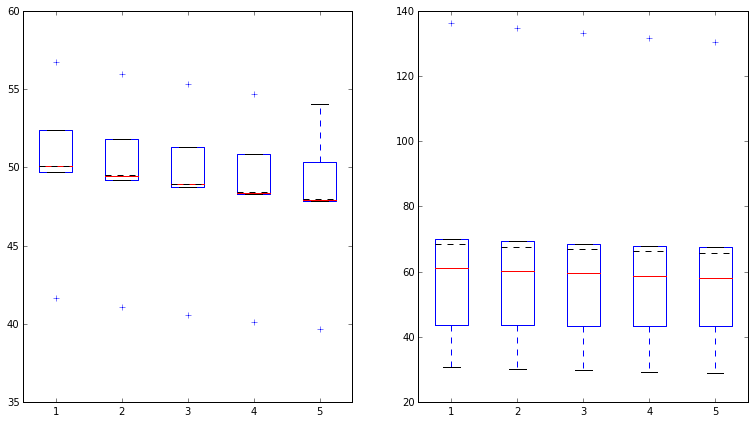

Training error: 45.8872186824
Testing error: 120.024573066
N° iterations: 40867
Beta: [ 1.43720533 -0.04057143  4.0226625  -2.77802689 -0.03653825  3.64010465
  2.10119705 -0.06022569 -0.00855549 -0.05778693  2.21124518  0.63739464
  1.12758733]
###########################################################


###########################################################
Dataset: 16
Best alpha: 4.5e-07


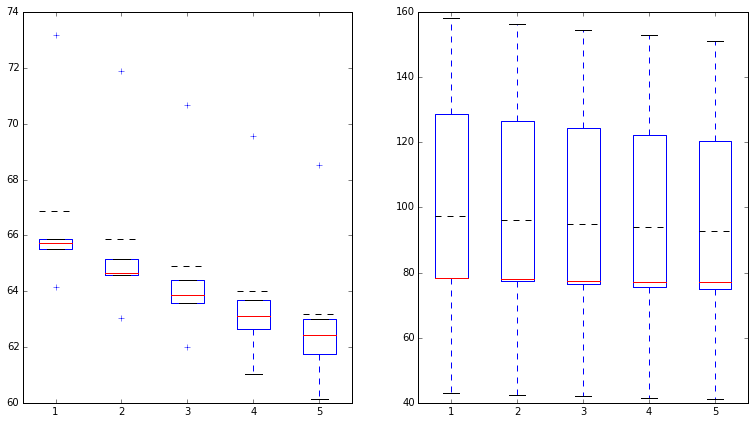

Training error: 59.139425774
Testing error: 84.7003440117
N° iterations: 36986
Beta: [ 1.37147973 -0.1547583   3.5693668  -2.0873361  -0.04933719  2.53340037
  2.83983954  0.13360542  0.03606145 -0.1020669   2.45305082  0.64342917
  1.71456752]
###########################################################


###########################################################
Dataset: 17
Best alpha: 4.5e-07


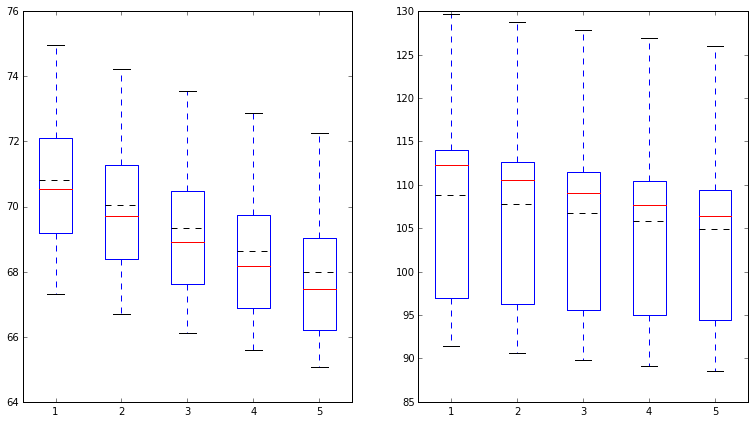

Training error: 65.8135992766
Testing error: 51.1345452402
N° iterations: 34201
Beta: [  1.45066635e+00   1.40254163e-02   3.23572578e+00  -3.08312487e+00
  -4.43118632e-02   3.26918045e+00   2.21879887e+00  -4.26989170e-01
   1.80029059e-03  -1.17261276e-01   2.33842394e+00   7.37167697e-01
   1.59336071e+00]
###########################################################


###########################################################
Dataset: 18
Best alpha: 4.5e-07


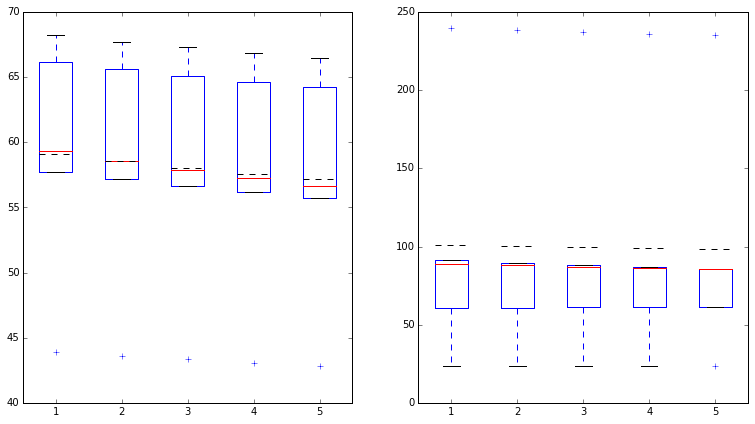

Training error: 56.780939942
Testing error: 89.4773158001
N° iterations: 33354
Beta: [ 1.17689517 -0.07783277  3.53481394 -2.65591502 -0.03921211  3.61282897
  2.47130703  0.2446926  -0.0098728  -0.12333678  1.93528643  0.6529232
  1.29935921]
###########################################################


###########################################################
Dataset: 19
Best alpha: 4.5e-07


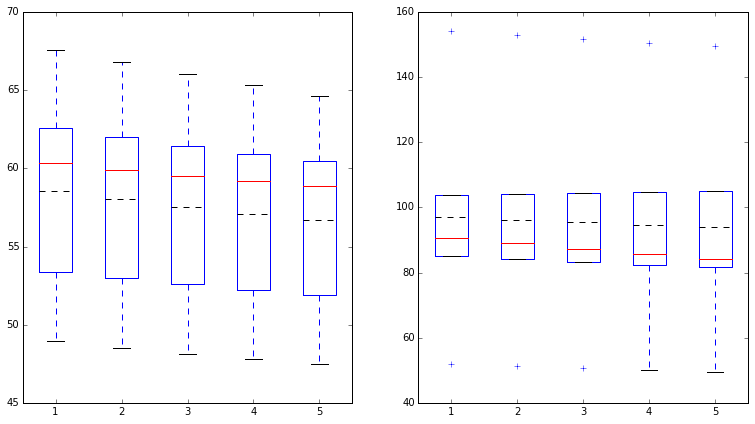

Training error: 56.4175529102
Testing error: 95.239291694
N° iterations: 35897
Beta: [ 1.23565231 -0.05168928  4.18735482 -2.21174459 -0.01562184  2.89906904
  2.01898636 -0.26377775  0.01035346 -0.09947827  2.45861275  0.76203972
  1.23868021]
###########################################################




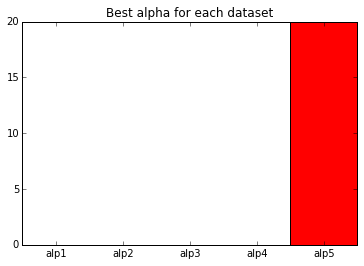

In [53]:
solve_all(gd_online, params=params2)

### Gradient descent online for rescaled data [0,1]

###########################################################
Dataset: 0
Best alpha: 0.0006


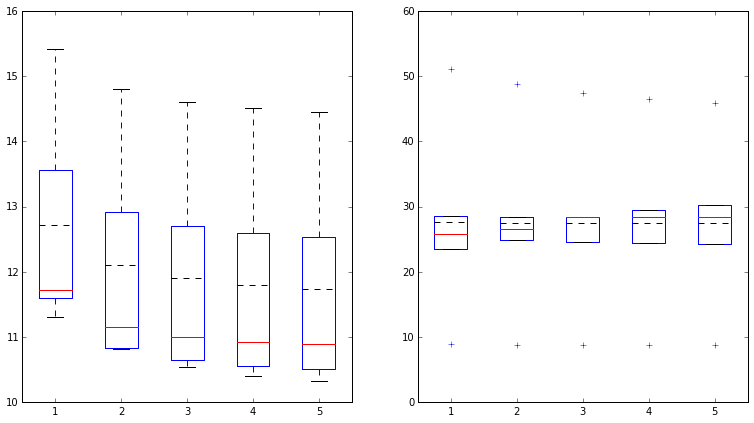

Training error: 13.0074188914
Testing error: 65.2775158068
N° iterations: 7716
Beta: [ 39.11586288 -21.13773613  18.38923592 -16.19356204 -15.68824135
  40.11271443  16.08682569 -16.63465575  -5.85040966 -13.0824112
   5.18382194   9.84443059  23.10824319]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.001


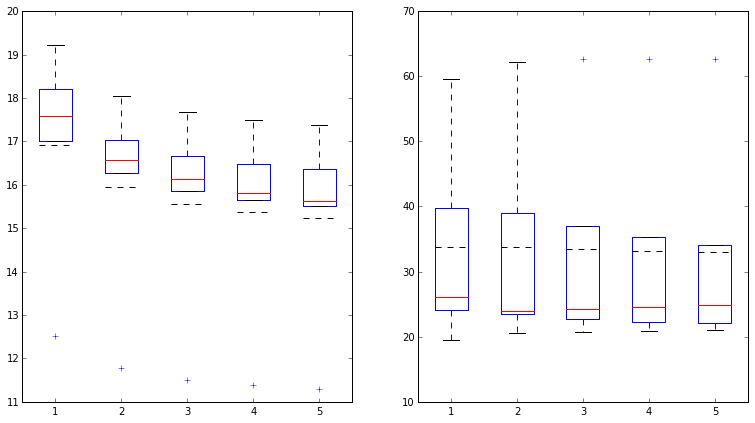

Training error: 16.3629180412
Testing error: 93.6913520605
N° iterations: 5746
Beta: [ 37.80887213 -23.95322312  19.39327228 -14.79894787 -11.32872383
  36.1662421   15.88312906 -12.44975647  -4.65662256 -10.82793002
   4.01509246   9.21796703  21.2663034 ]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.001


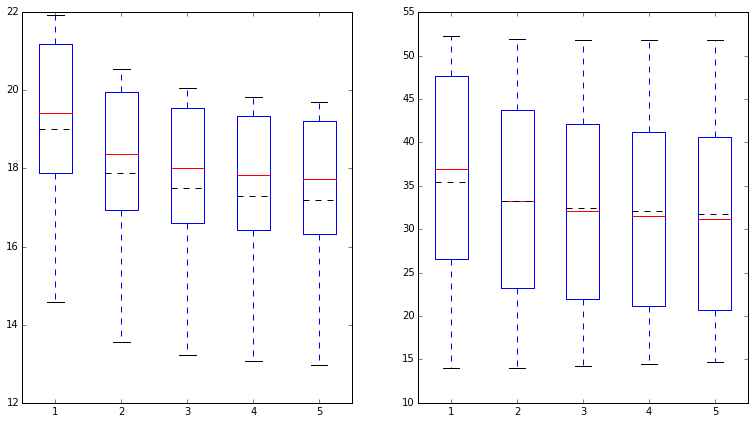

Training error: 18.1476046506
Testing error: 115.411791641
N° iterations: 5749
Beta: [ 40.9489742  -26.28235074  20.33139676 -15.11195554 -12.24402805
  40.31182297  15.19769008 -12.60908075  -8.9699999  -12.91452276
   6.47728044   8.49847185  20.73740758]
###########################################################


###########################################################
Dataset: 3
Best alpha: 0.001


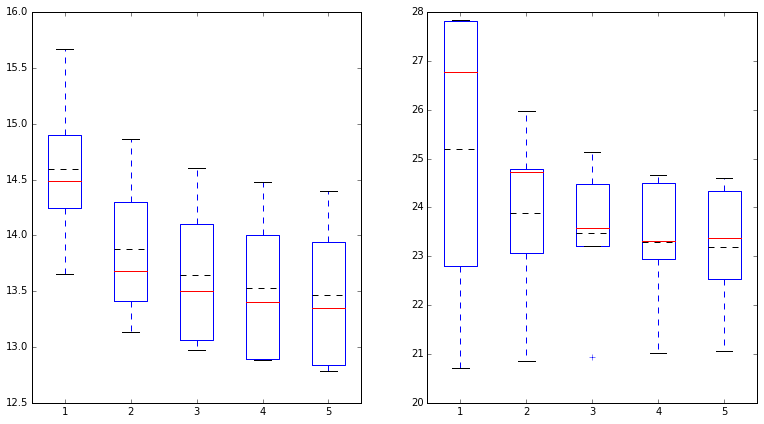

Training error: 14.1002166575
Testing error: 171.566596167
N° iterations: 5201
Beta: [ 43.49018308 -23.85853844  18.98344467 -14.95202504 -12.1583394
  40.80331668  14.35175172 -11.24176064  -6.87524737 -13.6501334
   4.78827187   5.17495125  17.34449177]
###########################################################


###########################################################
Dataset: 4
Best alpha: 0.001


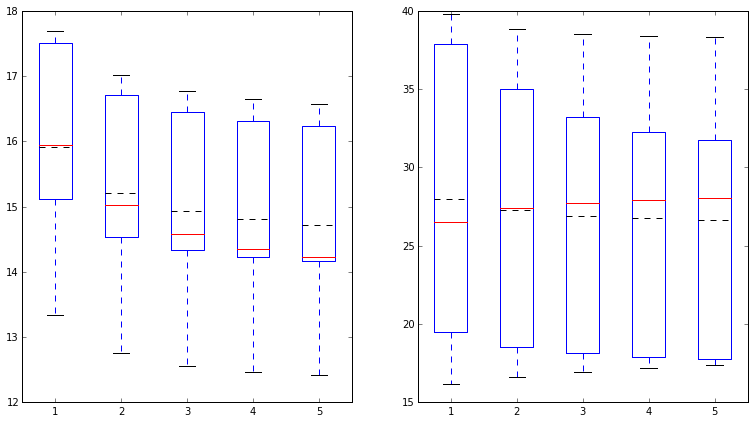

Training error: 15.5749021184
Testing error: 55.4869693485
N° iterations: 4778
Beta: [ 38.16630109 -22.84308976  19.39591174 -16.33510516 -14.17245842
  36.20337397  15.16860443 -14.7734468   -4.32181674 -13.31127047
   5.56611042  10.02100913  15.19797522]
###########################################################


###########################################################
Dataset: 5
Best alpha: 0.0002


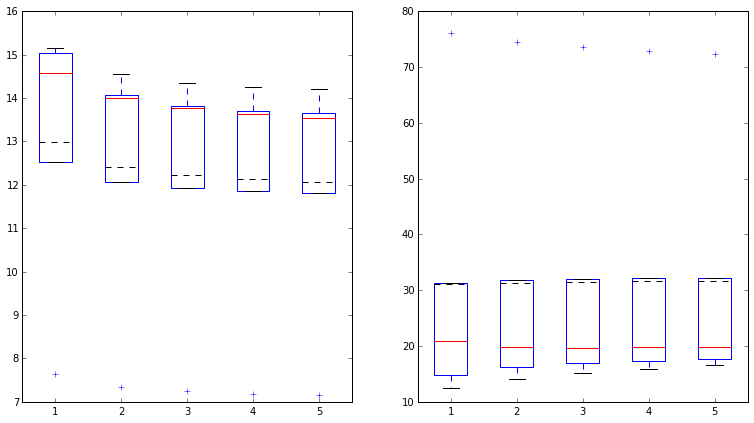

Training error: 14.260531204
Testing error: 53.7282011004
N° iterations: 13100
Beta: [ 38.96976544 -22.34314408  18.61113866 -14.99196224 -16.4775526
  33.29892644  18.75297401 -15.87593444   2.06279054 -11.26660572
   2.96264895   8.07907385  19.51108878]
###########################################################


###########################################################
Dataset: 6
Best alpha: 0.0002


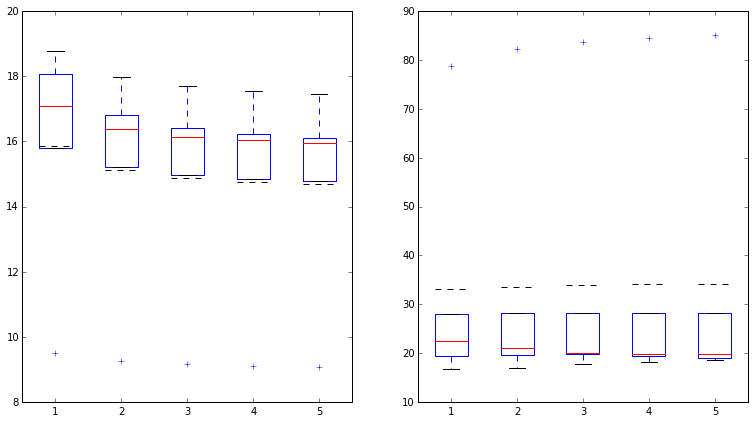

Training error: 17.0406053124
Testing error: 138.43489681
N° iterations: 11305
Beta: [ 41.70537973 -20.51468956  16.38510742 -14.07633648 -14.51562622
  29.64228774  15.74157789 -15.09346069   2.57167432 -13.15508491
   4.9732647    4.81542873  19.61305984]
###########################################################


###########################################################
Dataset: 7
Best alpha: 0.001


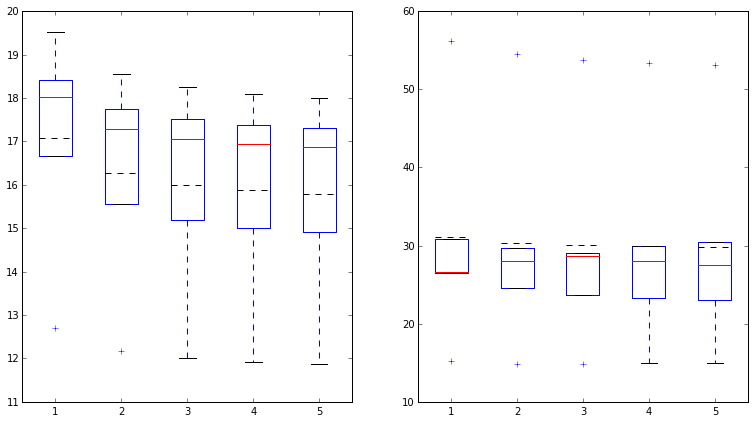

Training error: 16.780307963
Testing error: 47.5944048007
N° iterations: 4857
Beta: [ 35.2480786  -23.15145473  19.23595622 -16.67896879 -15.71852015
  39.09314526  17.41315759 -14.276876    -4.94742376 -13.13560909
   5.36157762  11.07107692  21.66338542]
###########################################################


###########################################################
Dataset: 8
Best alpha: 0.0004


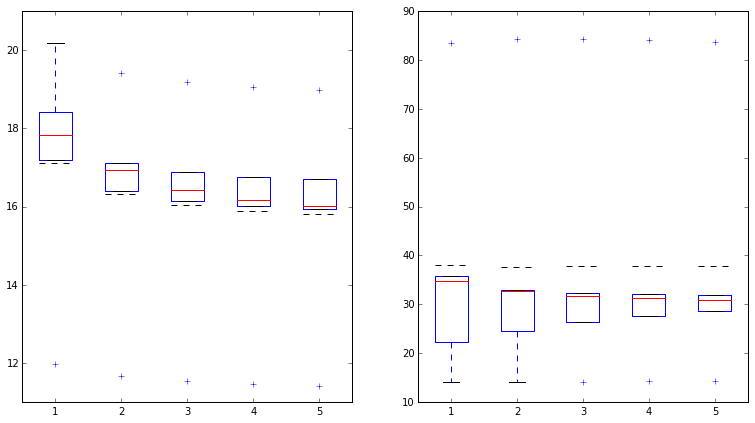

Training error: 17.6584519859
Testing error: 27.7337192325
N° iterations: 8709
Beta: [ 37.41995808 -21.95482948  17.92809616 -15.08771712 -13.95663336
  34.58616294  10.67114651 -17.43617686  -2.37350393 -12.39548795
   4.753583    11.76972412  24.43647518]
###########################################################


###########################################################
Dataset: 9
Best alpha: 0.0008


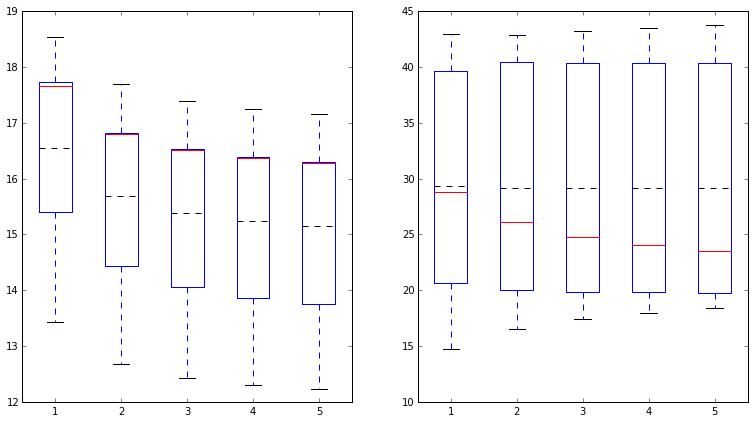

Training error: 16.1913895977
Testing error: 342.077775481
N° iterations: 6117
Beta: [ 35.90701919 -23.41505969  21.87404379 -16.81903859 -14.48762237
  31.34812684  15.46286692 -14.50588998 -11.7273665  -14.84503355
   5.82806483  12.68208273  20.88961168]
###########################################################


###########################################################
Dataset: 10
Best alpha: 0.001


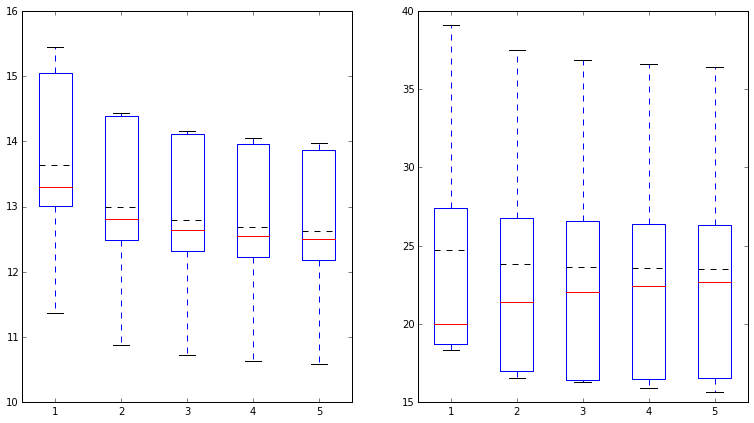

Training error: 13.4256912568
Testing error: 75.9971396011
N° iterations: 4894
Beta: [ 42.54113681 -21.13440371  21.98544949 -15.68010844 -15.44269464
  35.87185129  16.59204801 -13.43516556  -4.50264801 -10.58390068
   3.68384403   3.33175117  18.38727695]
###########################################################


###########################################################
Dataset: 11
Best alpha: 0.0002


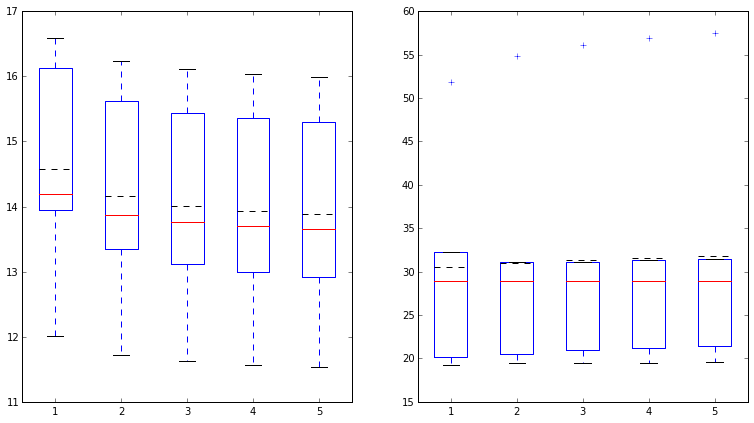

Training error: 15.8160994494
Testing error: 29.6439787773
N° iterations: 9605
Beta: [ 42.78348356 -21.42701966  18.90774127 -20.04112356 -13.23681841
  20.77435603  11.83625484 -15.3512919    0.08537344 -13.37791816
   4.28997618   9.81457422  19.08132893]
###########################################################


###########################################################
Dataset: 12
Best alpha: 0.0004


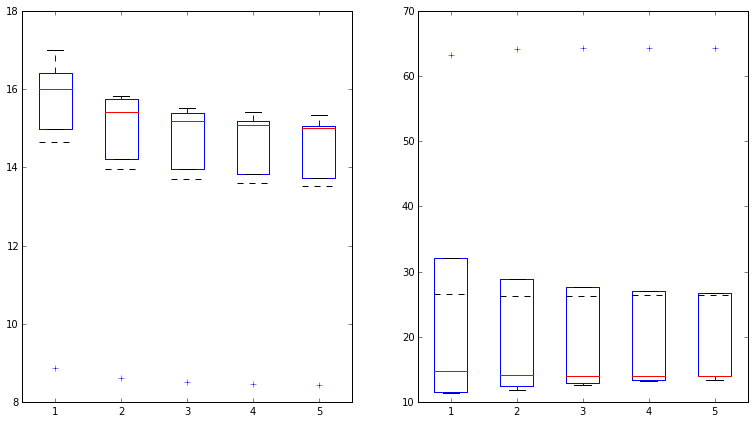

Training error: 14.7899074557
Testing error: 79.7909631268
N° iterations: 8755
Beta: [ 40.66777342 -23.02638729  17.83846681 -17.49348115 -14.65792097
  31.25304482  12.54506571 -17.1602068   -0.67965045  -8.30471092
   3.77956488  12.54896354  19.39813543]
###########################################################


###########################################################
Dataset: 13
Best alpha: 0.001


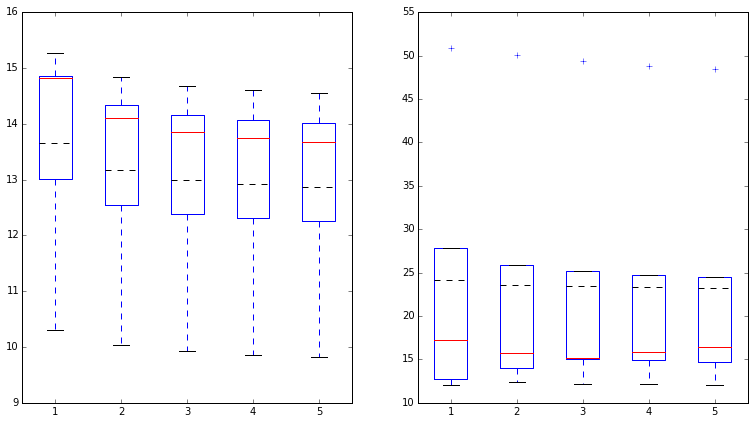

Training error: 13.5241617939
Testing error: 245.88695962
N° iterations: 4210
Beta: [ 39.0532525  -25.45496925  15.06380461 -14.00845838 -14.80020139
  28.6386264   13.88947301 -19.15394255  -5.2151324  -12.57719778
   5.26418977  13.42216396  25.17334677]
###########################################################


###########################################################
Dataset: 14
Best alpha: 0.0004


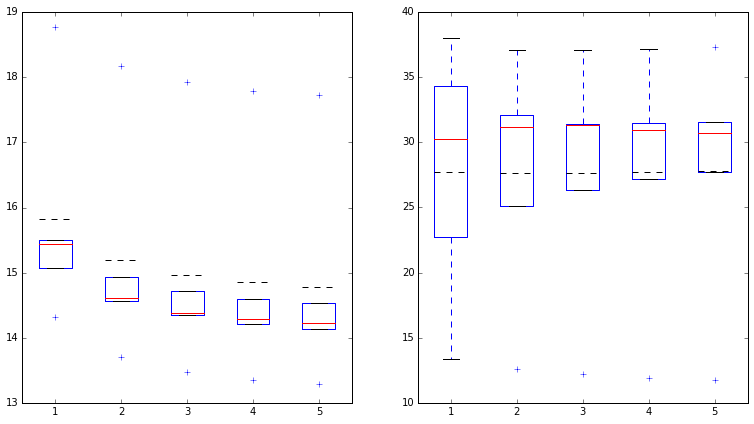

Training error: 16.0677328294
Testing error: 116.829116646
N° iterations: 7064
Beta: [ 34.73450412 -22.09303313  19.13751004 -17.56842087 -12.90745353
  24.70228606  16.79769427 -12.87780319  -0.27587361  -9.28366899
   4.82556481   7.73872531  21.85695518]
###########################################################


###########################################################
Dataset: 15
Best alpha: 0.001


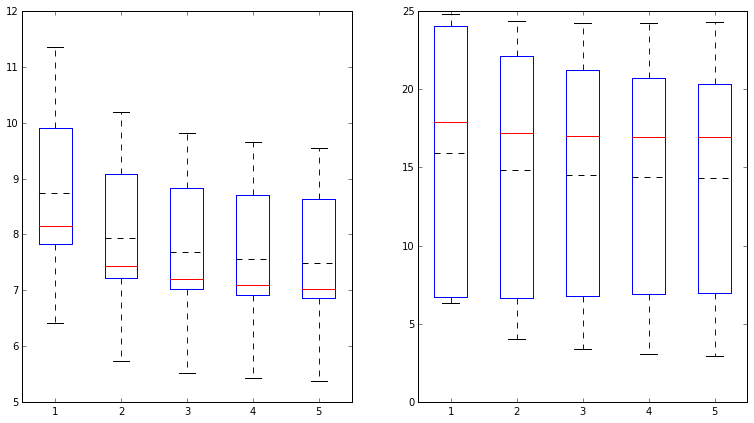

Training error: 7.96097566712
Testing error: 102.830744793
N° iterations: 8653
Beta: [ 49.01449326 -14.01102152  17.66161064 -18.43914135 -13.48116156
  43.60772004  11.17246879 -19.1564036  -10.87941785  -6.44038857
   2.47919828   3.68496473   4.65714851]
###########################################################


###########################################################
Dataset: 16
Best alpha: 0.001


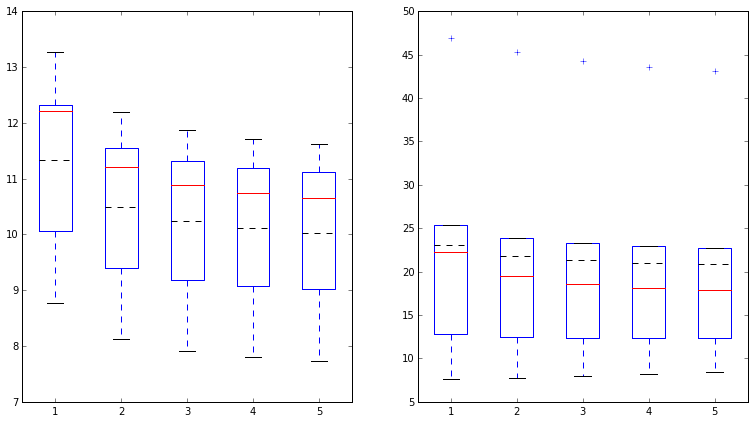

Training error: 10.700077422
Testing error: 507.801818338
N° iterations: 7355
Beta: [ 38.47766614 -24.64330759  21.1080902  -16.49817207 -14.3896562   42.658153
  16.46038099 -13.19435308 -10.78560131 -10.29593351   3.96120174
  12.02308714  20.01530468]
###########################################################


###########################################################
Dataset: 17
Best alpha: 0.001


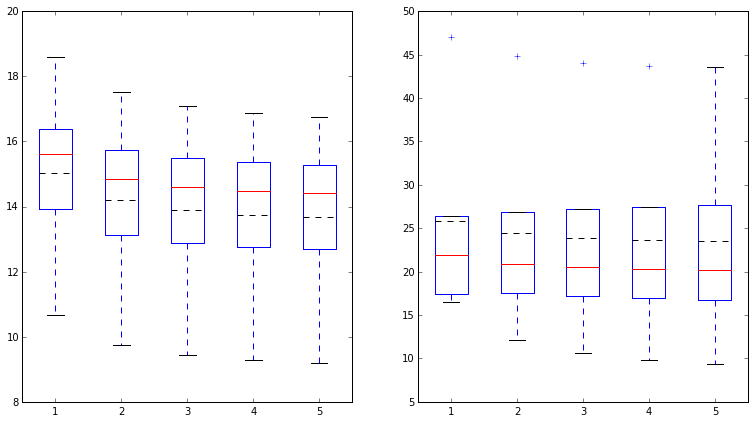

Training error: 14.3060025597
Testing error: 73.3125213211
N° iterations: 5340
Beta: [ 42.4908146  -22.92940627  19.90336775 -12.77593785 -13.35571895
  36.11922085  14.46491006 -13.37829593  -4.5480669  -13.58528428
   4.74098198   6.95403471  18.36625413]
###########################################################


###########################################################
Dataset: 18
Best alpha: 0.001


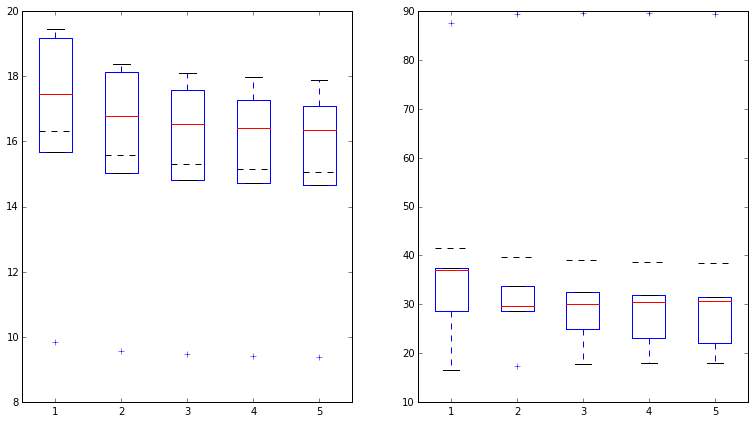

Training error: 16.4046917857
Testing error: 100.697687488
N° iterations: 4968
Beta: [ 41.63930017 -23.15925736  18.04482304 -16.16078615 -12.63576925
  39.98820255  14.97061548 -12.91900485  -6.27166264 -12.75357549
   5.67343499   6.43488305  18.58466997]
###########################################################


###########################################################
Dataset: 19
Best alpha: 0.0004


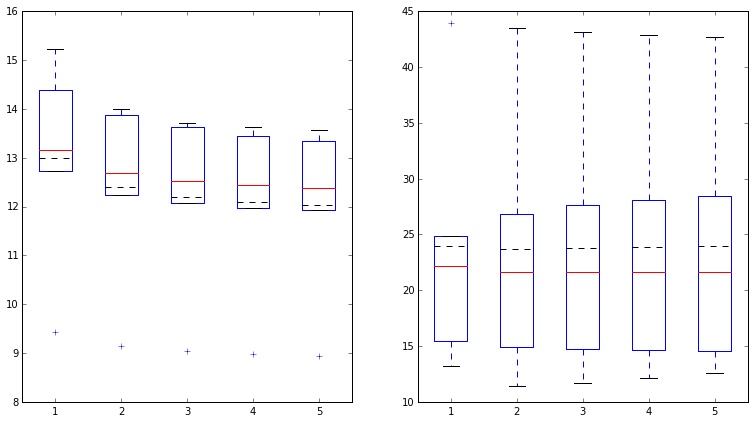

Training error: 13.1946751264
Testing error: 79.7129789852
N° iterations: 8855
Beta: [ 41.62832389 -20.53088785  17.59167949 -15.96918377 -13.44069352
  33.85965671  11.46215301 -16.64693932  -3.90664061  -9.81402788
   4.54243709  10.43394077  12.00674887]
###########################################################




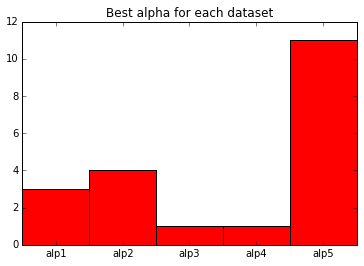

In [54]:
solve_all(gd_online, params=params1, data_func=rescale)

### Gradient descent online for normalized data

###########################################################
Dataset: 0
Best alpha: 0.0002


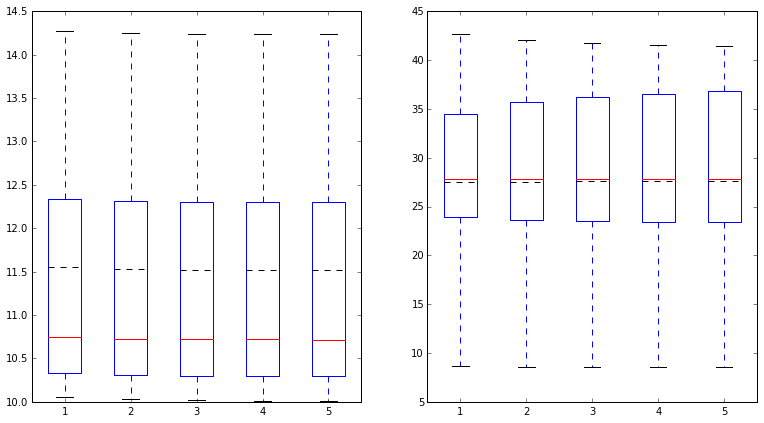

Training error: 12.7265440344
Testing error: 38.3704391845
N° iterations: 1534
Beta: [ 42.22651525  -4.04140807   4.26533568  -3.4473847   -3.91726341
   7.94397391   3.2690175   -4.13530417  -1.98042413  -3.21060613
   2.3436141    1.78623768   3.68635631]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.0002


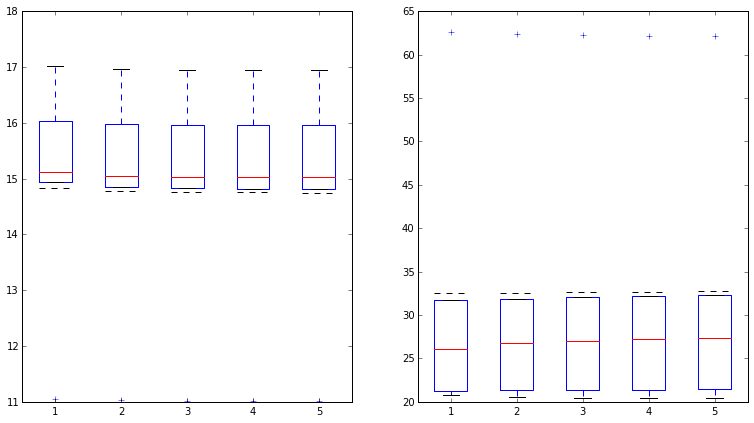

Training error: 16.0711580478
Testing error: 65.2908059333
N° iterations: 1891
Beta: [ 43.84338408  -4.66470646   4.32715625  -3.20692277  -3.14882485
   7.50409763   2.85182033  -3.44653668  -1.87895278  -2.32291694
   1.84388203   1.79465722   3.47214   ]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.0006


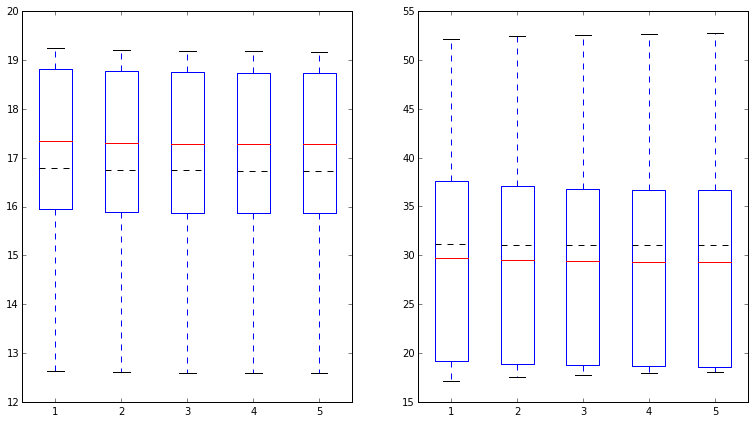

Training error: 17.7880949034
Testing error: 18.0041725612
N° iterations: 728
Beta: [ 42.41195618  -4.50015431   4.68287131  -3.17932875  -3.25734941
   8.25883348   3.13412632  -3.14088561  -2.96846469  -3.09932196
   2.98311732   1.67382891   3.66659256]
###########################################################


###########################################################
Dataset: 3
Best alpha: 0.0002


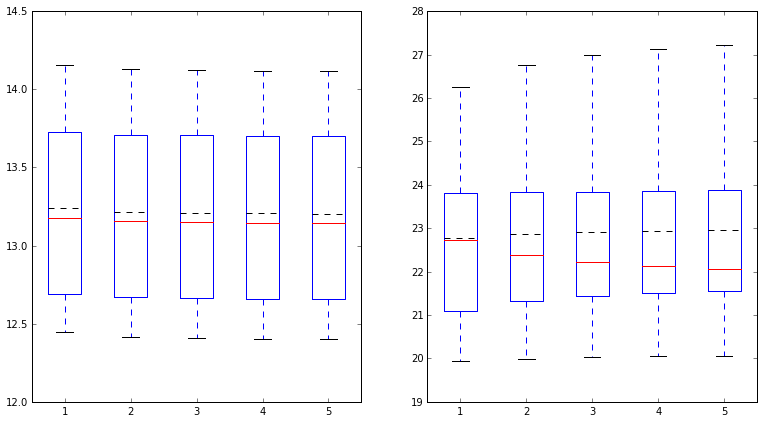

Training error: 13.9375577433
Testing error: 48.6369000543
N° iterations: 1201
Beta: [ 43.11730718  -4.47842204   4.35541027  -3.15273712  -3.39507043
   6.59805483   3.2747364   -2.92543188  -1.79378685  -3.28189372
   2.10223152   0.88524763   2.65683055]
###########################################################


###########################################################
Dataset: 4
Best alpha: 0.0002


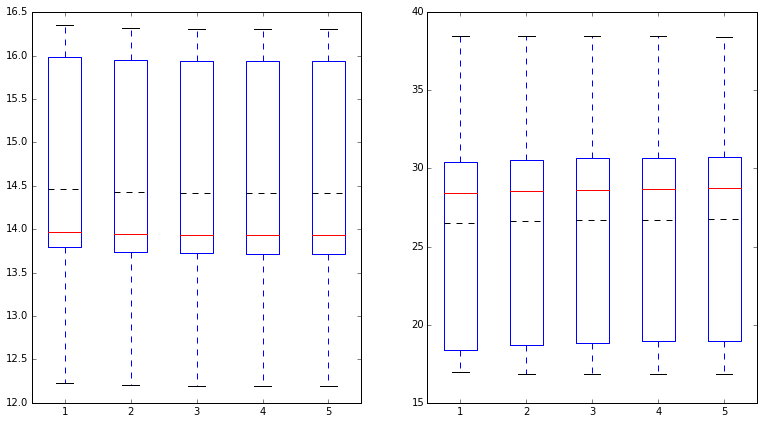

Training error: 15.3892917875
Testing error: 24.1745417821
N° iterations: 1428
Beta: [ 42.22327523  -4.40803047   4.34264828  -3.29826084  -3.46388093
   7.15932827   2.74984143  -3.5461942   -1.4797015   -2.95094954
   2.45285449   1.64024515   2.80719336]
###########################################################


###########################################################
Dataset: 5
Best alpha: 0.0002


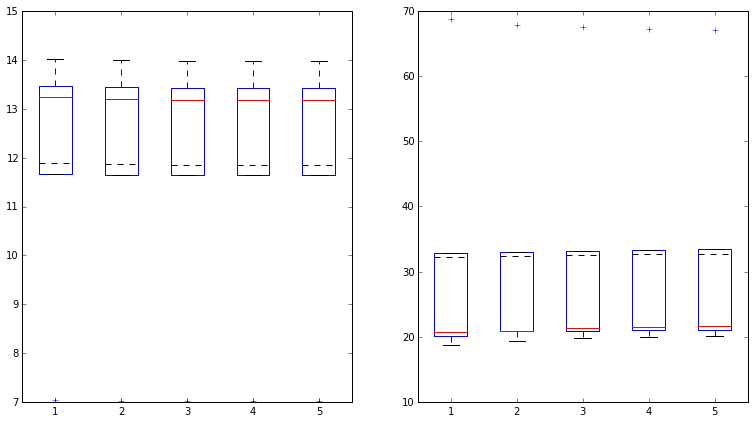

Training error: 13.370563385
Testing error: 27.1142854438
N° iterations: 1263
Beta: [ 41.80242862  -4.39558964   4.17624139  -2.85751631  -3.94715089
   7.09985519   3.57617416  -3.67984202  -0.82988173  -2.64460527
   1.5522779    1.48789439   3.22229807]
###########################################################


###########################################################
Dataset: 6
Best alpha: 0.001


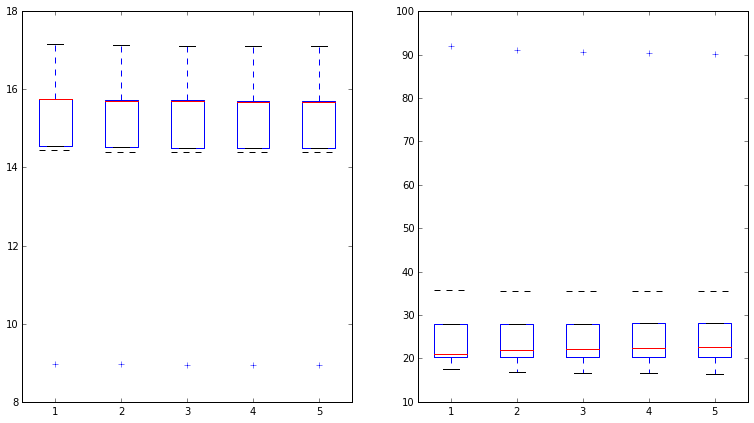

Training error: 15.7815019554
Testing error: 50.2731709417
N° iterations: 376
Beta: [ 43.18952653  -4.55856358   4.01148462  -2.42656557  -3.52873853
   7.35883925   3.03930598  -3.66891775  -1.39273994  -3.17020095
   2.48761624   1.34436962   3.35323608]
###########################################################


###########################################################
Dataset: 7
Best alpha: 0.0002


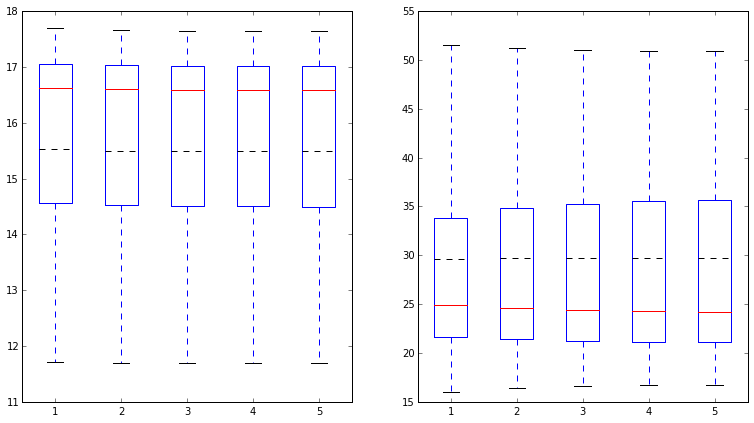

Training error: 16.5841646531
Testing error: 28.0681605601
N° iterations: 1364
Beta: [ 42.58177712  -4.29394421   4.54041502  -3.62445333  -4.01698322
   7.51533385   3.00293547  -3.35446518  -1.56941749  -2.79419943
   2.41743857   1.99001714   3.72274907]
###########################################################


###########################################################
Dataset: 8
Best alpha: 0.0002


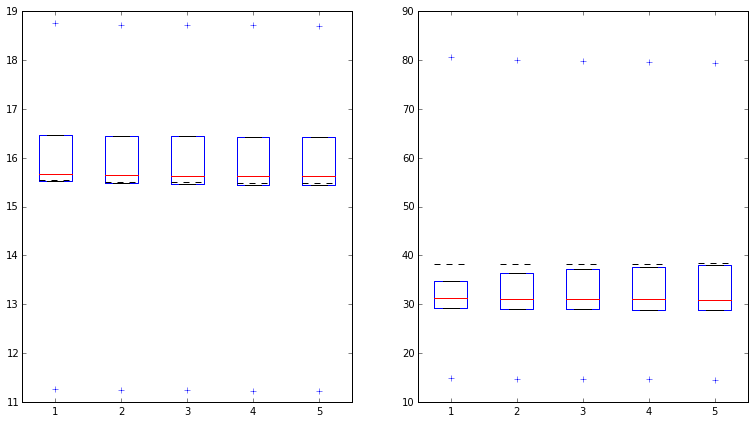

Training error: 17.0797739827
Testing error: 18.6695277152
N° iterations: 1402
Beta: [ 41.40720128  -4.01428852   4.08337746  -2.94853721  -3.52525073
   7.39319241   2.58951643  -4.38396698  -1.5651302   -3.04194662
   2.16858518   2.33619972   4.04095072]
###########################################################


###########################################################
Dataset: 9
Best alpha: 0.0002


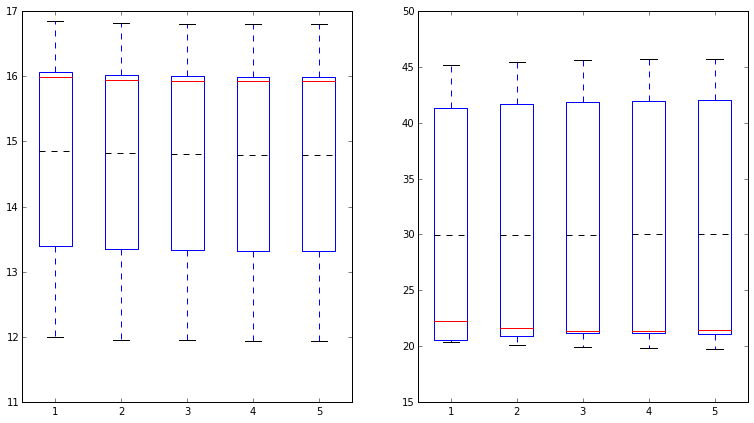

Training error: 15.892886139
Testing error: 32.407908827
N° iterations: 1876
Beta: [ 41.79785562  -4.27054657   5.09369912  -3.57726344  -3.78632543
   7.61933849   2.90289587  -3.80289715  -3.26550235  -3.34908673
   2.63334279   2.41089059   3.71223487]
###########################################################


###########################################################
Dataset: 10
Best alpha: 0.0002


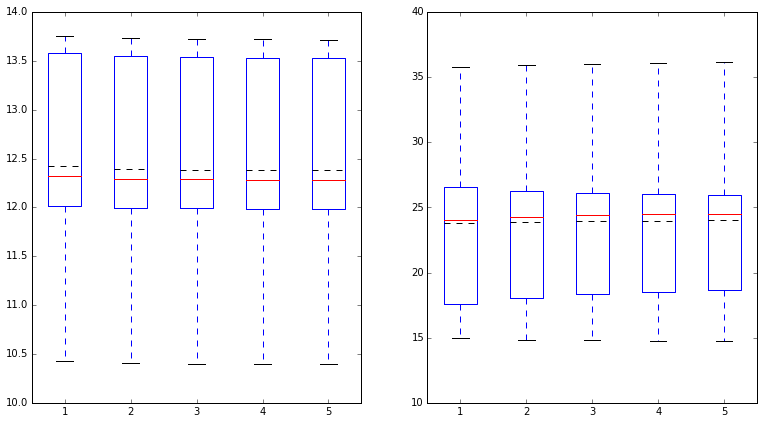

Training error: 13.2804573566
Testing error: 52.0015285506
N° iterations: 1344
Beta: [ 43.12135784  -3.90920646   4.88932406  -2.88137313  -3.52332081
   7.01112598   2.9910523   -3.55281147  -1.37088817  -2.34734275
   1.60444089   0.77881803   2.97403762]
###########################################################


###########################################################
Dataset: 11
Best alpha: 0.0002


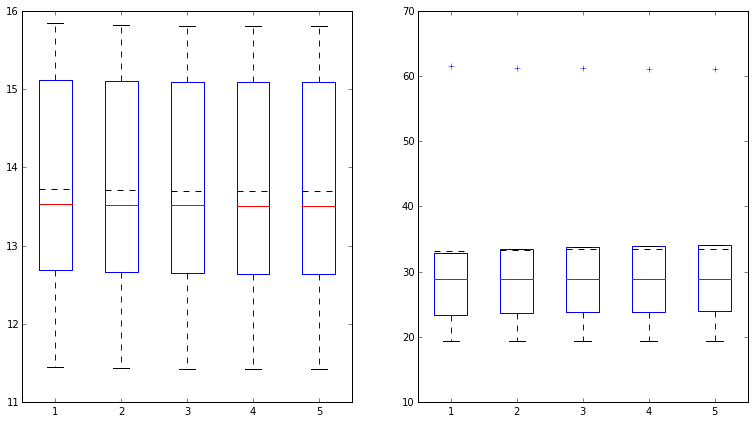

Training error: 15.1230550605
Testing error: 58.2777057111
N° iterations: 1095
Beta: [ 40.60007827  -4.12921709   4.12266475  -3.91058836  -3.35235828
   5.02384271   2.51030137  -3.88682003  -0.8668188   -2.98928464
   1.91598746   2.17858081   2.93230127]
###########################################################


###########################################################
Dataset: 12
Best alpha: 0.0002


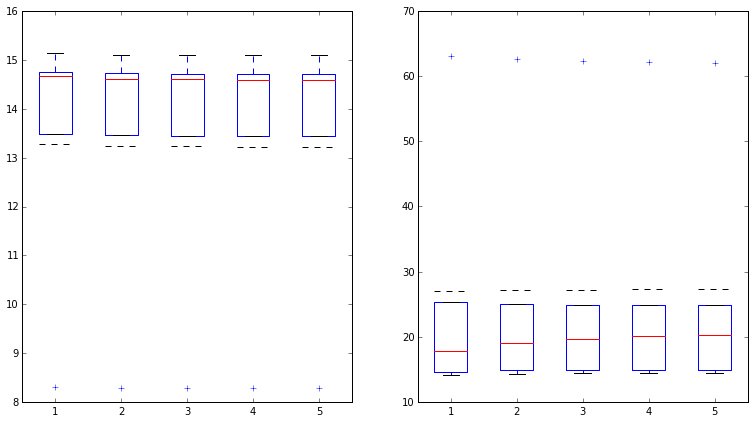

Training error: 14.2703041781
Testing error: 33.5181606162
N° iterations: 1487
Beta: [ 42.7746075   -4.19391837   3.73165741  -3.57482438  -3.67724151
   6.87063209   2.17638323  -4.37136805  -1.23040461  -1.9129881
   1.81239288   2.43981611   3.40788556]
###########################################################


###########################################################
Dataset: 13
Best alpha: 0.0008


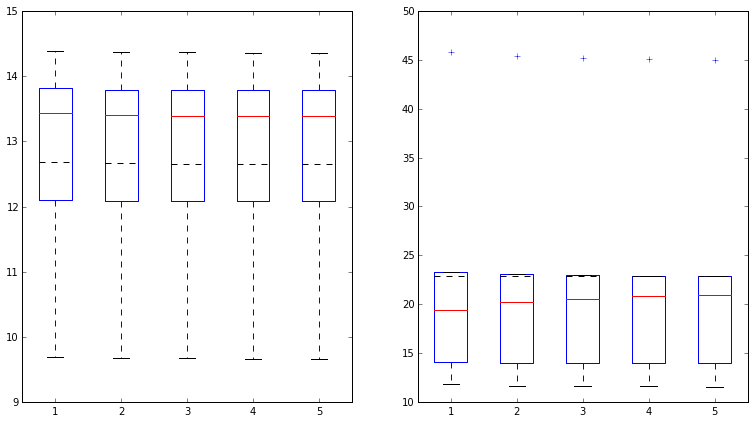

Training error: 13.3663998961
Testing error: 49.3798234136
N° iterations: 400
Beta: [ 42.51091744  -4.46260179   3.45266944  -2.54493574  -3.73511494
   6.75219485   2.23005097  -4.77946964  -1.50276957  -3.17784157
   2.32347788   2.42684321   4.33863177]
###########################################################


###########################################################
Dataset: 14
Best alpha: 0.0002


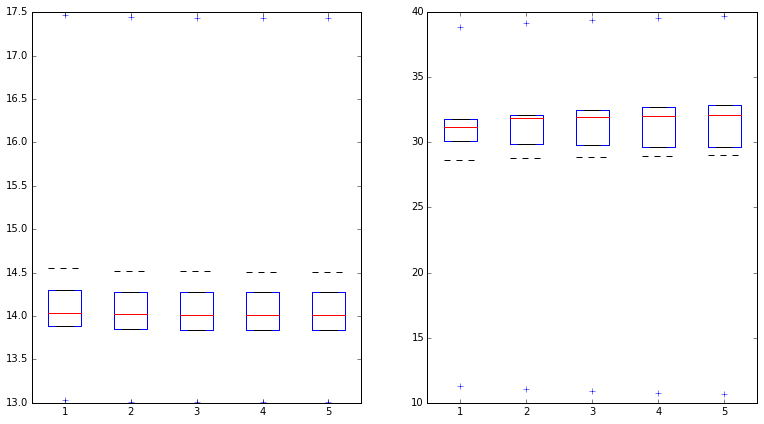

Training error: 15.5578083558
Testing error: 62.0802332363
N° iterations: 1246
Beta: [ 40.90051166  -4.41111303   4.65629245  -3.23988907  -3.02102368
   6.15780585   3.18893045  -3.01289097  -0.72534675  -1.94083012
   2.23955199   1.67463493   3.75080069]
###########################################################


###########################################################
Dataset: 15
Best alpha: 0.0002


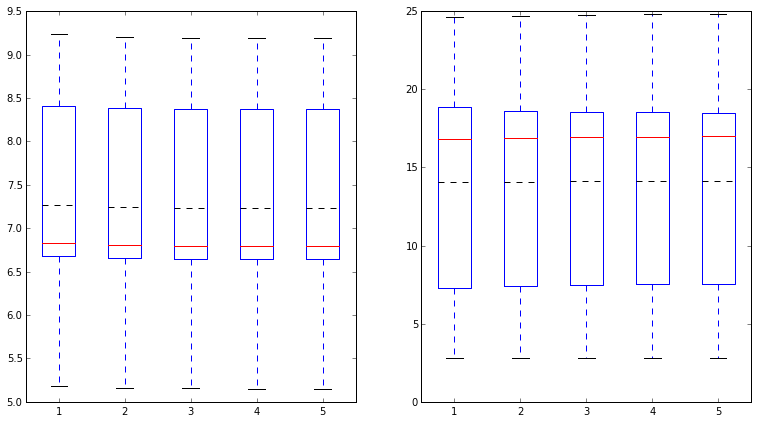

Training error: 7.7830831329
Testing error: 103.525379024
N° iterations: 2414
Beta: [ 42.47204064  -2.16760796   3.95445915  -3.63961559  -3.35156614
   8.32504171   1.72947087  -4.85879866  -3.09314051  -1.05864695
   1.04990459   0.68609459   0.87977248]
###########################################################


###########################################################
Dataset: 16
Best alpha: 0.001


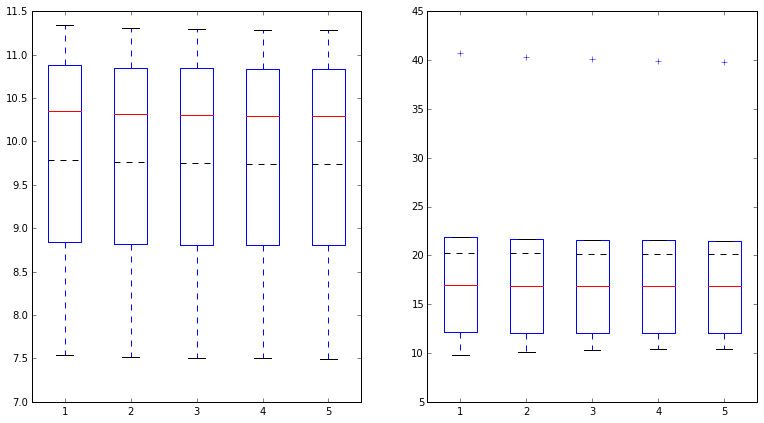

Training error: 10.4703925557
Testing error: 80.0407382824
N° iterations: 606
Beta: [ 43.06467964  -4.51384116   4.96864542  -2.94988192  -3.73157716
   9.09292501   2.58683838  -3.61830878  -3.47573941  -1.92014292
   1.77998379   2.30442052   3.39130654]
###########################################################


###########################################################
Dataset: 17
Best alpha: 0.0002


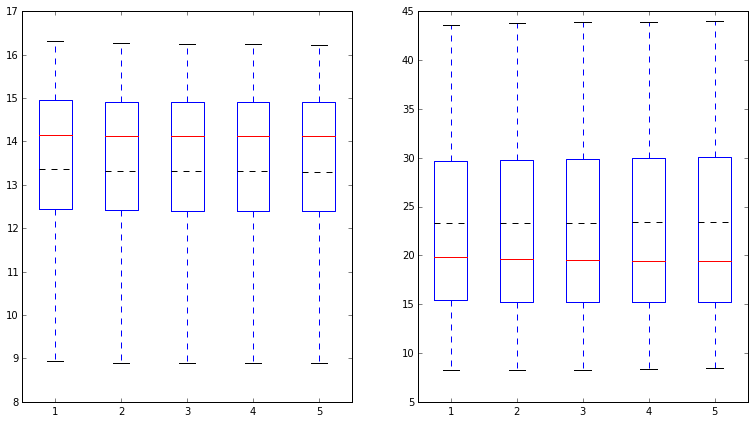

Training error: 14.0814594646
Testing error: 39.0982468252
N° iterations: 1486
Beta: [ 42.70622023  -4.65737534   4.61082841  -2.17601745  -3.3294304
   6.7877859    2.58651085  -3.54344371  -1.53203751  -2.9214066
   1.98400841   1.29372391   3.15138051]
###########################################################


###########################################################
Dataset: 18
Best alpha: 0.001


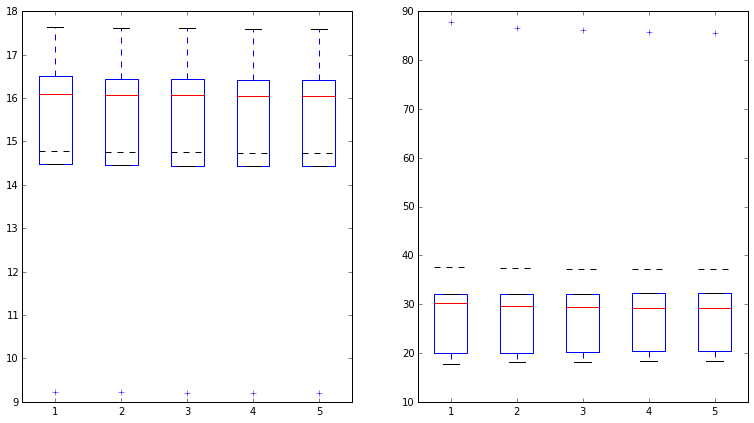

Training error: 16.1771940462
Testing error: 19.2541349743
N° iterations: 323
Beta: [ 42.39178558  -4.0945883    4.24387105  -3.51732597  -3.11014058
   7.3346674    3.25274358  -2.82813694  -1.92573502  -2.68391111
   2.50377871   0.92418085   3.09191652]
###########################################################


###########################################################
Dataset: 19
Best alpha: 0.0008


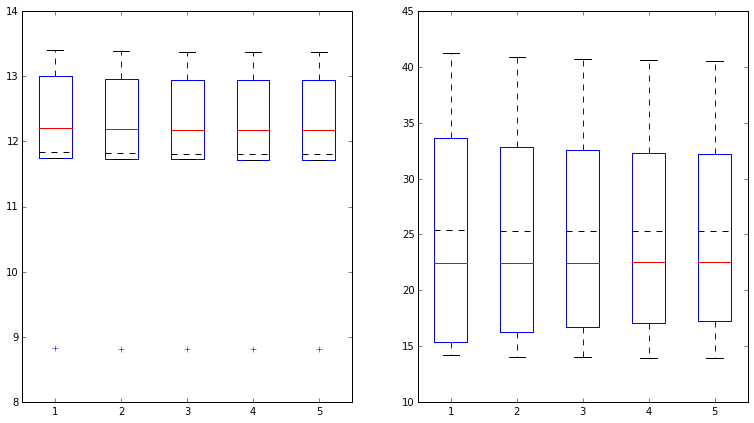

Training error: 12.74837702
Testing error: 41.4471018701
N° iterations: 456
Beta: [ 42.14822129  -3.834324     4.29024049  -2.75491875  -2.98404716
   7.38759533   2.01109875  -4.29613239  -2.01894494  -2.27534431
   2.15332112   2.06195479   2.65112701]
###########################################################




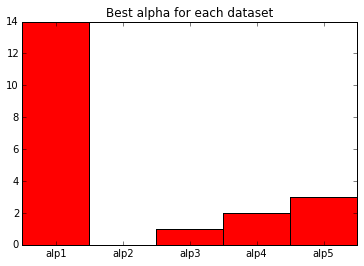

In [55]:
solve_all(gd_online, params=params1, data_func=normalize)

### Newton-Raphson for raw data

In [56]:
solve_all(nr_linear)

###########################################################
Dataset: 0
Training error: 12.690235978
Testing error: 29.8692128464
N° iterations: 2
Beta: [ 27.77312374  -0.19196441   3.64271996  -2.61978866  -0.04940511
   3.27558724   0.8950743   -0.94639251  -0.03448292  -0.13677948
   2.89862662  12.4397042   13.71043458]
###########################################################


###########################################################
Dataset: 1
Training error: 15.9947888908
Testing error: 19.1213963039
N° iterations: 2
Beta: [ 32.77556027  -0.21889642   4.01031224  -2.79387988  -0.03884453
   3.10643719   0.67461777  -0.80667426  -0.03700155  -0.11417401
   2.23319673  12.31980684  12.62588456]
###########################################################


###########################################################
Dataset: 2
Training error: 17.7637059001
Testing error: 13.1702299683
N° iterations: 2
Beta: [ 30.97809856  -0.22930608   4.12593951  -2.51735014  -0.04283795
   3.4

### Newton-Rhapson for rescaled data [0,1]

In [57]:
solve_all(nr_linear, data_func=rescale)

###########################################################
Dataset: 0
Training error: 12.690235978
Testing error: 70.8230012379
N° iterations: 2
Beta: [ 37.68776506 -21.30804932  18.21359978 -15.71873198 -15.80963497
  45.85822131  16.11133741 -17.03506525 -10.86211949 -13.67794787
   5.79725325  12.4397042   24.27432442]
###########################################################


###########################################################
Dataset: 1
Training error: 15.9947888908
Testing error: 105.300112485
N° iterations: 2
Beta: [ 36.81035813 -24.29750213  20.05156121 -13.96939941 -11.2649135
  43.49012072  14.84159095 -12.9067882  -11.98850316 -11.41740083
   4.46639345  12.31980684  22.35412861]
###########################################################


###########################################################
Dataset: 2
Training error: 17.7637059001
Testing error: 139.177707921
N° iterations: 2
Beta: [ 39.98319337 -25.45297468  20.62969754 -15.10410084 -12.42300501
  47.71

### Newton-Raphson for normalized data

In [58]:
solve_all(nr_linear, data_func=normalize)

###########################################################
Dataset: 0
Training error: 12.690235978
Testing error: 39.1167896725
N° iterations: 2
Beta: [ 42.22724     -3.99216233   4.26196505  -3.44486437  -3.93375017
   8.28671753   3.23536861  -4.20056151  -2.37742955  -3.2700182
   2.44555845   1.89445678   3.72993749]
###########################################################


###########################################################
Dataset: 1
Training error: 15.9947888908
Testing error: 67.378076989
N° iterations: 2
Beta: [ 43.83778667  -4.60702487   4.40931759  -3.16661632  -3.13637015
   8.12721232   2.6937296   -3.56195787  -2.65364237  -2.37489256
   1.94115486   1.99611526   3.53901282]
###########################################################


###########################################################
Dataset: 2
Training error: 17.7637059001
Testing error: 18.9190672901
N° iterations: 2
Beta: [ 42.41314667  -4.37995712   4.69576307  -3.21485752  -3.29190982
   8.568

## Locally weighted